# Parte Redes Neuronales:

Se cargan todas las librerias usadas en esta parte

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf
import xarray as xr 

#Modelos clasificacion:

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

#Modelos regresion:

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

#XGBoost:

import xgboost as xgb

#Funciones para diagramas:

from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#Metrica de clasificación:

from sklearn.metrics import accuracy_score

# Métricas de regresion:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score


#U_net:

from keras_unet_collection import models

#Guardar
from tensorflow.keras.models import load_model


Se cargan los datos:

In [2]:
#Entrenamiento:
df_t = pd.read_csv('lowres_features_train.csv')

#Validacion:
df_v = pd.read_csv('lowres_features_val.csv')

#Test:
df_test = pd.read_csv('lowres_features_test.csv')

In [3]:
np.shape(df_t)

(60000, 38)

In [4]:
df_t.head()

,q000_ir,q001_ir,q010_ir,q025_ir,q050_ir,q075_ir,q090_ir,q099_ir,q100_ir,q000_wv,...,q001_vl,q010_vl,q025_vl,q050_vl,q075_vl,q090_vl,q099_vl,q100_vl,label_class,label_reg
0,-2.196238,-1.949695,-1.791281,-1.528253,-1.010820,0.495947,1.456004,1.500297,1.509985,-3.016850,...,-0.206396,-0.206396,-0.206396,-0.206396,0.029683,0.789612,7.986002,24.557011,1.0,600.0
1,-2.097033,-1.949780,-1.785856,-1.546079,-0.995319,0.398583,1.445153,1.498747,1.511147,-2.861186,...,-0.206396,-0.206396,-0.206396,-0.206396,0.023692,0.789612,6.997860,23.928528,1.0,555.0
2,-2.191200,-1.950458,-1.779152,-1.547726,-1.009851,0.329993,1.425157,1.496798,1.508822,-3.032837,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.834176,7.185461,23.316002,1.0,486.0
3,-2.069906,-1.953159,-1.768301,-1.545692,-0.995707,0.253361,1.396985,1.494484,1.504172,-2.798920,...,-0.206396,-0.206396,-0.206396,-0.206396,0.012161,0.807767,6.642037,24.557011,1.0,356.0
4,-2.038905,-1.955155,-1.766751,-1.539879,-0.963930,0.217225,1.364627,1.492547,1.506885,-2.714777,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.861273,8.199336,22.719021,1.0,416.0


Como se visualiza, los datasets de entrenamiento estan formados por 60.000 entradas de datos distribuidos en 38 columnas en las cuales las primeras 36 son los disitntos cuantiles de cada dataset previamente usados (IR, VL, ...), la columna 37 nos denota si es o no una tomenta.

Se va a proceder a realizar una comparación de los rendimientos de los anteriores modelos vsitos en la primera parte respecto de las redes neuronales que se contruiran

Primero se procede a volver a reentrenar los modelos previos con estos mismos datos

## Reentrenamiento de modelos previos:

Primero se realizarán los modelos de clasificacion:

In [96]:
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,36]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,36]

In [97]:
model_list = [LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),LinearSVC(dual=False),xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')]

In [98]:
for model in tqdm.tqdm(model_list):
    model.fit(X_t,y_t)

C:\Users\Usuario\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\envs\tf\lib\site-packages\xgboost\training.py:183: UserWarning: [14:34:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
100%|██████████| 7/7 [01:02<00:00,  8.96s/it]


In [100]:
for idx,model in enumerate(model_list):
    #predicciones 
    yhat = model.predict(X_v)
    
    #metrica de error
    accuracy = accuracy_score(y_v,yhat)
    
    print('{} accuracy: {}%'.format(model_list[idx],np.round(accuracy*100,0)))

LogisticRegression() accuracy: 89.0%
GaussianNB() accuracy: 85.0%
DecisionTreeClassifier() accuracy: 86.0%
RandomForestClassifier() accuracy: 90.0%
GradientBoostingClassifier() accuracy: 90.0%
LinearSVC(dual=False) accuracy: 89.0%
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree

De forma análoga con los modelos de regresión:

In [101]:
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,37]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,37]

In [102]:
model_list = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),LinearSVR(),xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100)]

In [103]:
for model in tqdm.tqdm(model_list):
    model.fit(X_t,y_t)

100%|██████████| 6/6 [03:13<00:00, 32.28s/it]


In [ ]:


for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    
    mae = mean_absolute_error(y_v,yhat)
    rmse = abs(np.sqrt(mean_squared_error(y_v,yhat)))
    bias = abs(np.mean(yhat - y_v))
    r2 = r2_score(y_v,yhat)

    print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: LinearRegression | R2: 0.6185 | MAE: 61.7133 | RMSE: 117.0673 | Bias: 19.0938
Method: DecisionTreeRegressor | R2: 0.2540 | MAE: 63.5563 | RMSE: 163.7067 | Bias: 7.7641
Method: RandomForestRegressor | R2: 0.6344 | MAE: 45.6393 | RMSE: 114.6000 | Bias: 11.2243
Method: GradientBoostingRegressor | R2: 0.6678 | MAE: 46.3343 | RMSE: 109.2468 | Bias: 15.3743
Method: LinearSVR | R2: 0.4930 | MAE: 56.6742 | RMSE: 134.9611 | Bias: 36.4499
Method: XGBRegressor | R2: 0.6377 | MAE: 45.4488 | RMSE: 114.0848 | Bias: 14.6450


## ANNs:

En este apartado se va a realizar el entrenamiento de dos ANNs, la primera a base de los datos tabulares antes usados por lo modelos tradicionales de ML en el apartado anterior, y a su vez, un nuevo dataset, correspodiente a las mismas entradas previas pero en su forma de imagen, que a su vez también será en conjunto de datos usado para el entrenamiento de la CNN y U-Net.

Primero se hará la ANNs para los datos tabulares previos, para ello carguemos los datos:

In [9]:
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,36]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,36]

Se transforman los datos para suministrarselo a la ANNs

In [10]:
#Se crean los tensores
ds_train = tf.data.Dataset.from_tensor_slices((X_t,y_t))
ds_val = tf.data.Dataset.from_tensor_slices((X_v,y_v))

#Se mexclan losd atos para que no esten en el mismo orden
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#Se hacen en lotes de 32 para hacer mas eficiente el entrenamiento, asi guardamos RAM
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

Se procede a crear un modelo:

In [11]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Dense(2,activation='relu',input_shape=(X_t.shape[1],),),
        #hidden layer 1
        tf.keras.layers.Dense(2,activation='relu'),
        #output layer 
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 74        
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


Se entrena:

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),metrics='accuracy')

history = model.fit(ds_train,validation_data=ds_val,epochs=25)

Epoch 1/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4704 - accuracy: 0.8213 - val_loss: 0.3636 - val_accuracy: 0.8726
Epoch 2/25
1875/1875 [==============================] - 2s 966us/step - loss: 0.2928 - accuracy: 0.8977 - val_loss: 0.2988 - val_accuracy: 0.8792
Epoch 3/25
1875/1875 [==============================] - 2s 964us/step - loss: 0.2623 - accuracy: 0.9004 - val_loss: 0.2814 - val_accuracy: 0.8800
Epoch 4/25
1875/1875 [==============================] - 2s 953us/step - loss: 0.2530 - accuracy: 0.9007 - val_loss: 0.2766 - val_accuracy: 0.8783
Epoch 5/25
1875/1875 [==============================] - 2s 961us/step - loss: 0.2491 - accuracy: 0.9010 - val_loss: 0.2680 - val_accuracy: 0.8882
Epoch 6/25
1875/1875 [==============================] - 2s 961us/step - loss: 0.2465 - accuracy: 0.9011 - val_loss: 0.2760 - val_accuracy: 0.8779
Epoch 7/25
1875/1875 [==============================] - 2s 956us/step - loss: 0.2455 - accuracy: 0.9017 - val_loss: 0.2712 - v

Se procede a mirar si hay signos de sobreajuste, según el numero de iteraciones realizadas:

Text(0, 0.5, 'loss')

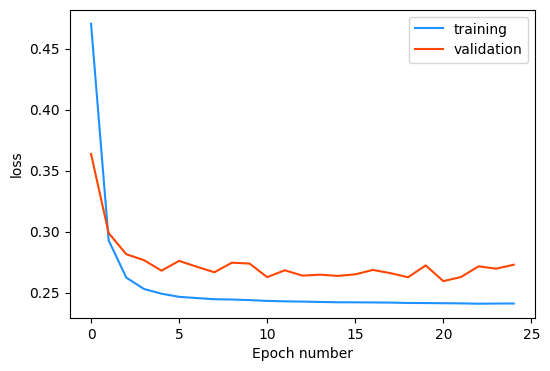

In [13]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],color='dodgerblue',label='training')
plt.plot(history.history['val_loss'],color='orangered',label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')

No se ven signos de sobreajuste, visibles

Veamos el rendimiento de las predicciones

361/361 [==============================] - 0s 651us/step


Text(0, 0.5, 'count')

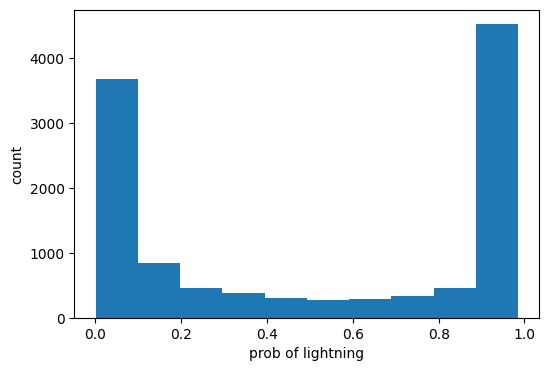

In [14]:
plt.figure(figsize=(6,4))
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')

Se procede a realizar un diagrama de rendimiento

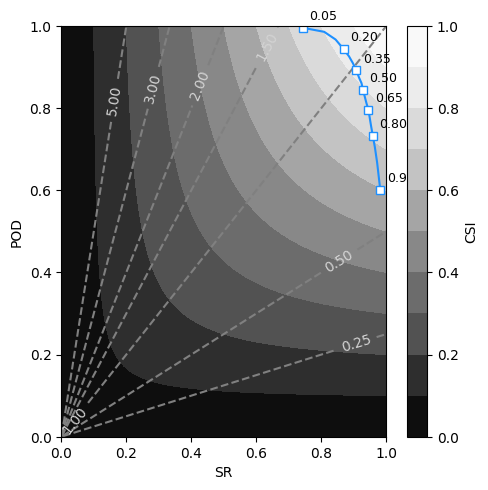

In [15]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    #plot text and marker every 3rd point, because every point was too many
    if np.mod(i,3) == 0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.plot(np.asarray(srs)[i],np.asarray(pods)[i],'s',color='dodgerblue',markerfacecolor='w')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='black')

plt.tight_layout()

Saquemosle el accuracy para poder compararlo con los modelos de clasificación tradicionales:

In [17]:
y_pred_prob = model.predict(X_v)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()
acc = accuracy_score(y_v, y_pred_classes)
print(f"\n Accuracy en conjunto de validación: {acc:.4f}")

361/361 [==============================] - 0s 581us/step

 Accuracy en conjunto de validación: 0.8765


## ANN Regresion:

Veamos ahora la ANN para regresión, primero carguemos los datos:

In [6]:
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,37]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,37]

Creamos los tensores para darselos a la ANN y los ponemos de forma que se escojan datos aletorios:

In [7]:
#Se crean los tensores
ds_train = tf.data.Dataset.from_tensor_slices((X_t,y_t))
ds_val = tf.data.Dataset.from_tensor_slices((X_v,y_v))

#Se mexclan losd atos para que no esten en el mismo orden
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#Se hacen en lotes de 32 para hacer mas eficiente el entrenamiento, asi guardamos RAM
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

Procedemos a crear un modelo:

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(2,activation='relu',input_shape=(X_t.shape[1],),))
model.add(Dense(2,activation='relu'))
model.add(Dense(1))

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 2)                 74        
                                                                 
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',loss='mse')

In [16]:
history = model.fit(ds_train,validation_data=ds_val,epochs=250)

Epoch 1/250
1875/1875 [==============================] - 2s 925us/step - loss: 32705.0391 - val_loss: 38102.9766
Epoch 2/250
1875/1875 [==============================] - 2s 898us/step - loss: 32618.5879 - val_loss: 37981.4141
Epoch 3/250
1875/1875 [==============================] - 2s 882us/step - loss: 32537.6465 - val_loss: 37865.5508
Epoch 4/250
1875/1875 [==============================] - 2s 900us/step - loss: 32462.5039 - val_loss: 37757.2031
Epoch 5/250
1875/1875 [==============================] - 2s 897us/step - loss: 32391.5625 - val_loss: 37652.9180
Epoch 6/250
1875/1875 [==============================] - 2s 927us/step - loss: 32325.4180 - val_loss: 37554.0039
Epoch 7/250
1875/1875 [==============================] - 2s 923us/step - loss: 32263.6035 - val_loss: 37461.2188
Epoch 8/250
1875/1875 [==============================] - 2s 886us/step - loss: 32206.2754 - val_loss: 37372.9805
Epoch 9/250
1875/1875 [==============================] - 2s 887us/step - loss: 32153.6172 - val_

Text(0, 0.5, 'loss')

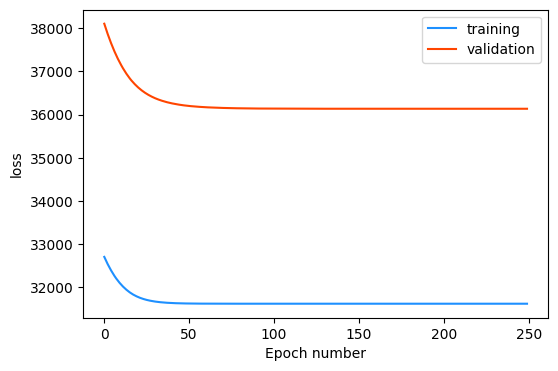

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],color='dodgerblue',label='training')
plt.plot(history.history['val_loss'],color='orangered',label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')

In [19]:
model.evaluate(ds_val)


361/361 [==============================] - 0s 706us/step - loss: 36134.2500


36134.25

No es muy eficiente, así que vamos a añadir más neuronas:

In [21]:
model = Sequential()

model.add(Dense(128,activation='relu',input_shape=(X_t.shape[1],),))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               4736      
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(ds_train, validation_data=ds_val, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 3s 1ms/step - loss: 14293.8750 - root_mean_squared_error: 119.5570 - val_loss: 12515.3857 - val_root_mean_squared_error: 111.8722
Epoch 2/50
1875/1875 [==============================] - 2s 1ms/step - loss: 12604.7119 - root_mean_squared_error: 112.2707 - val_loss: 13805.4727 - val_root_mean_squared_error: 117.4967
Epoch 3/50
1875/1875 [==============================] - 2s 1ms/step - loss: 12010.0889 - root_mean_squared_error: 109.5906 - val_loss: 12442.9600 - val_root_mean_squared_error: 111.5480
Epoch 4/50
1875/1875 [==============================] - 2s 1ms/step - loss: 11393.5771 - root_mean_squared_error: 106.7407 - val_loss: 11683.3428 - val_root_mean_squared_error: 108.0895
Epoch 5/50
1875/1875 [==============================] - 2s 1ms/step - loss: 10951.8457 - root_mean_squared_error: 104.6511 - val_loss: 14212.2949 - val_root_mean_squared_error: 119.2153
Epoch 6/50
1875/1875 [==============================] - 2s 1ms/step - 

Text(0, 0.5, 'loss')

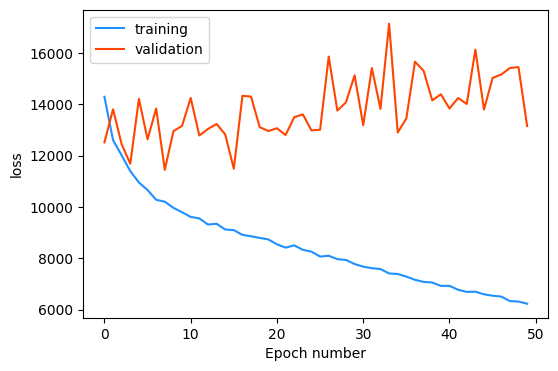

In [23]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],color='dodgerblue',label='training')
plt.plot(history.history['val_loss'],color='orangered',label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')

In [24]:
loss, rmse = model.evaluate(ds_val)
print(f"RMSE en validación: {rmse:.4f}")

361/361 [==============================] - 0s 770us/step - loss: 13152.8311 - root_mean_squared_error: 114.6858
RMSE en validación: 114.6858


Vemos que hay signos de overfitting, así que vamos a apagar neuronas de forma aleatoria:

In [25]:
from tensorflow.keras.layers import Dropout

In [26]:
model = Sequential()

model.add(Dense(128,activation='relu',input_shape=(X_t.shape[1],),))
model.add(Dropout(0.33))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               4736      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

In [27]:
history = model.fit(ds_train, validation_data=ds_val, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 3s 1ms/step - loss: 15980.8418 - root_mean_squared_error: 126.4154 - val_loss: 12691.1338 - val_root_mean_squared_error: 112.6549
Epoch 2/50
1875/1875 [==============================] - 3s 1ms/step - loss: 14131.2783 - root_mean_squared_error: 118.8751 - val_loss: 13847.8428 - val_root_mean_squared_error: 117.6769
Epoch 3/50
1875/1875 [==============================] - 3s 1ms/step - loss: 13772.4004 - root_mean_squared_error: 117.3559 - val_loss: 12518.5625 - val_root_mean_squared_error: 111.8864
Epoch 4/50
1875/1875 [==============================] - 3s 1ms/step - loss: 13442.3037 - root_mean_squared_error: 115.9409 - val_loss: 13196.3340 - val_root_mean_squared_error: 114.8753
Epoch 5/50
1875/1875 [==============================] - 3s 1ms/step - loss: 13123.4658 - root_mean_squared_error: 114.5577 - val_loss: 12684.9434 - val_root_mean_squared_error: 112.6275
Epoch 6/50
1875/1875 [==============================] - 3s 1ms/step - 

Text(0, 0.5, 'loss')

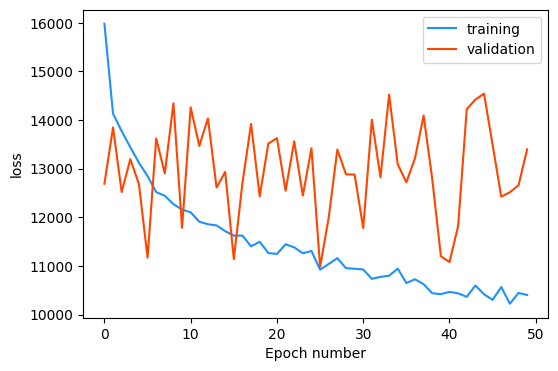

In [28]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],color='dodgerblue',label='training')
plt.plot(history.history['val_loss'],color='orangered',label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')

In [29]:
model = Sequential()

model.add(Dense(128,activation='relu',input_shape=(X_t.shape[1],),))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               4736      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                

In [30]:
history = model.fit(ds_train, validation_data=ds_val, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 3s 1ms/step - loss: 17793.8125 - root_mean_squared_error: 133.3934 - val_loss: 13662.9238 - val_root_mean_squared_error: 116.8885
Epoch 2/50
1875/1875 [==============================] - 3s 1ms/step - loss: 15778.4121 - root_mean_squared_error: 125.6122 - val_loss: 14076.4414 - val_root_mean_squared_error: 118.6442
Epoch 3/50
1875/1875 [==============================] - 3s 1ms/step - loss: 15254.7539 - root_mean_squared_error: 123.5101 - val_loss: 14227.0928 - val_root_mean_squared_error: 119.2774
Epoch 4/50
1875/1875 [==============================] - 3s 1ms/step - loss: 14869.9434 - root_mean_squared_error: 121.9424 - val_loss: 12762.1846 - val_root_mean_squared_error: 112.9698
Epoch 5/50
1875/1875 [==============================] - 3s 1ms/step - loss: 14564.5186 - root_mean_squared_error: 120.6835 - val_loss: 12061.6113 - val_root_mean_squared_error: 109.8254
Epoch 6/50
1875/1875 [==============================] - 3s 1ms/step - 

Text(0, 0.5, 'loss')

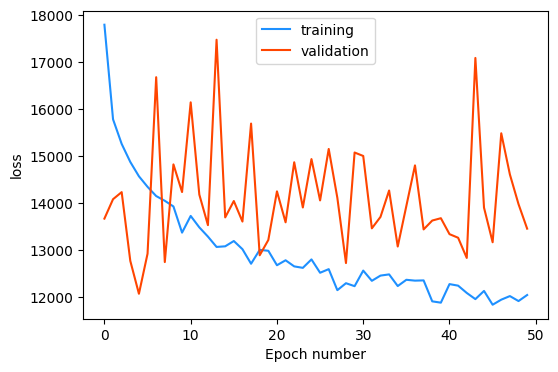

In [31]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],color='dodgerblue',label='training')
plt.plot(history.history['val_loss'],color='orangered',label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_t.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(1)  # salida regresión
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [33]:
history = model.fit(ds_train,validation_data=ds_val,epochs=100,callbacks=[early_stop])

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 33933.5195 - root_mean_squared_error: 184.2105 - val_loss: 37506.8242 - val_root_mean_squared_error: 193.6668
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 29063.7969 - root_mean_squared_error: 170.4811 - val_loss: 31330.7031 - val_root_mean_squared_error: 177.0048
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 24521.7500 - root_mean_squared_error: 156.5942 - val_loss: 26525.6992 - val_root_mean_squared_error: 162.8671
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 20780.1328 - root_mean_squared_error: 144.1532 - val_loss: 21322.9883 - val_root_mean_squared_error: 146.0239
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 18100.5586 - root_mean_squared_error: 134.5383 - val_loss: 17735.1387 - val_root_mean_squared_error: 133.1733
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/s

Text(0, 0.5, 'loss')

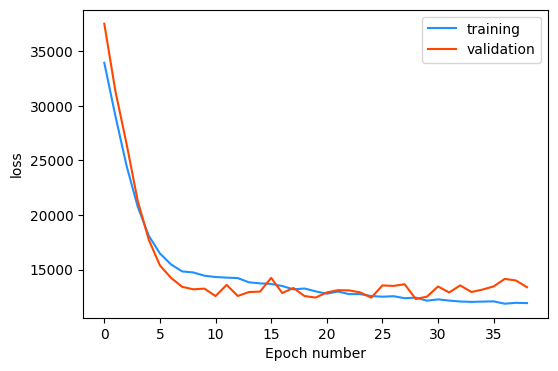

In [34]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],color='dodgerblue',label='training')
plt.plot(history.history['val_loss'],color='orangered',label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')

Este modelo, lo usaremos como final, ya que no hay signos de sobreajuste

In [35]:
loss, rmse = model.evaluate(ds_val)
print(f"RMSE en validación: {rmse:.4f}")

361/361 [==============================] - 0s 879us/step - loss: 12315.2803 - root_mean_squared_error: 110.9742
RMSE en validación: 110.9742


Vamos a sacar todos los posibles errores:

In [40]:
y_pred = model.predict(X_v)

361/361 [==============================] - 0s 715us/step


In [46]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [42]:
mean_absolute_error(y_v,y_pred)

48.23256207298941

RSME:

In [45]:
np.sqrt(mean_squared_error(y_v,y_pred))

110.97423898313882

In [47]:
r2_score(y_v,y_pred)

0.6572096408805483

Bias:

In [49]:
abs(np.mean(y_pred - y_v))

20.538675467950636

## CNN:

Ahora se realizará el mismo proceso pero para entrenar a una CNN ya que le suministraremos como dataset las imagenes de las cuales s ehan extraido las caracteristicas anteriores:

In [10]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [3]:
ds_train

<xarray.Dataset> Size: 3GB
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 480kB ...
  * n_channel       (n_channel) <U5 80B 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 480kB 2018-08-25T00:15:00 ... ...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 2GB ...
    label_1d_class  (n_samples) int8 60kB ...
    label_1d_reg    (n_samples) int16 120kB ...
    label_2d_class  (n_samples, x, y) int8 138MB ...
    label_2d_reg    (n_samples, x, y) int16 276MB ...

Como se observa tenemos 60.000 entradas de imágenes de 48x48pxl, como nuestros datosd  entrada, transformemoslas en tensores para poder suministrarlas a la CNN

In [11]:
#Hacer datasets
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_1d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_1d_class.values))

#Hacer el random seed del paper
tf.random.set_seed(42)

#se mezclan las entradas
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

Veamos un ejemplo del resultado:

<tf.Tensor: shape=(), dtype=int8, numpy=1>

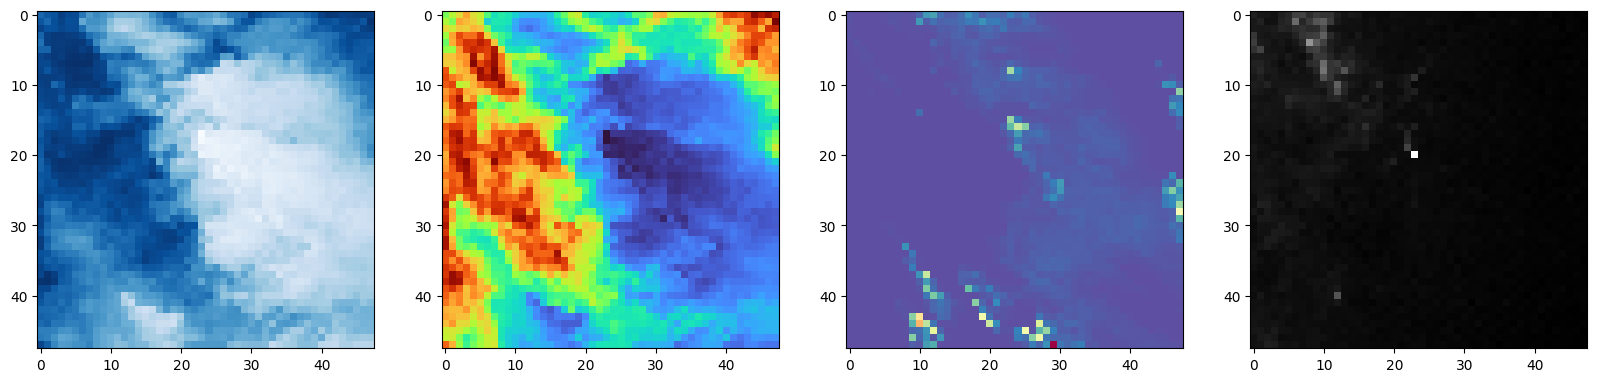

In [5]:
#Cogemos un grupo:
for batch in ds_train:
    break 

#get the features for example 11 in this batch 
one_example_features = batch[0][11]
#get the label for that same example 
one_example_label = batch[1][11]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

Ahora procedamos con la construccion de la CNN, solo hay 1 etaap de convolución con un filtro 3x3:

In [6]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(ds_train.element_spec[0].shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
        
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 1)         37        
                                                                 
 flatten (Flatten)           (None, 2116)              0         
                                                                 
 dense (Dense)               (None, 1)                 2117      
                                                                 
Total params: 2,154
Trainable params: 2,154
Non-trainable params: 0
_________________________________________________________________


Entrenemos el modelo, por 20 iteraciones:

In [7]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), metrics='accuracy')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

history = model.fit(ds_train,validation_data=ds_val,epochs=20)

Epoch 1/20
1875/1875 [==============================] - 70s 37ms/step - loss: 0.6257 - accuracy: 0.6575 - val_loss: 0.5943 - val_accuracy: 0.6981
Epoch 2/20
1875/1875 [==============================] - 56s 30ms/step - loss: 0.5982 - accuracy: 0.6870 - val_loss: 0.6246 - val_accuracy: 0.6847
Epoch 3/20
1875/1875 [==============================] - 39s 21ms/step - loss: 0.5884 - accuracy: 0.6961 - val_loss: 0.6947 - val_accuracy: 0.6439
Epoch 4/20
1875/1875 [==============================] - 55s 29ms/step - loss: 0.5819 - accuracy: 0.7021 - val_loss: 0.6031 - val_accuracy: 0.6820
Epoch 5/20
1875/1875 [==============================] - 53s 28ms/step - loss: 0.5772 - accuracy: 0.7066 - val_loss: 0.6101 - val_accuracy: 0.6866
Epoch 6/20
1875/1875 [==============================] - 68s 36ms/step - loss: 0.5735 - accuracy: 0.7094 - val_loss: 0.6018 - val_accuracy: 0.6999
Epoch 7/20
1875/1875 [==============================] - 65s 35ms/step - loss: 0.5705 - accuracy: 0.7106 - val_loss: 0.6217 -

Ahora busquemos signos de sobreajuste de nuestro modelo:

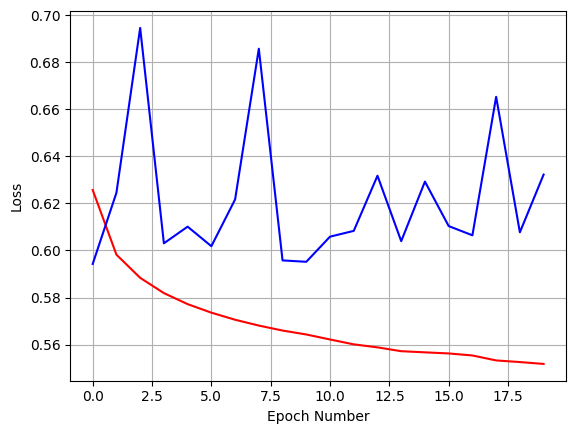

In [8]:
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

Realizando una vista rápida a las curvas de pérdida, podemos notar el rápido incremento a partir de la 17º iteración, por lo que vamos a volver a realizar pero esta vez quedemonos con 17 iteraciones, de todas formas, miremos el rendimiento de este modelo antes:

361/361 [==============================] - 0s 923us/step


Text(0.5, 1.0, 'Probabilidad CNN con 20 iter')

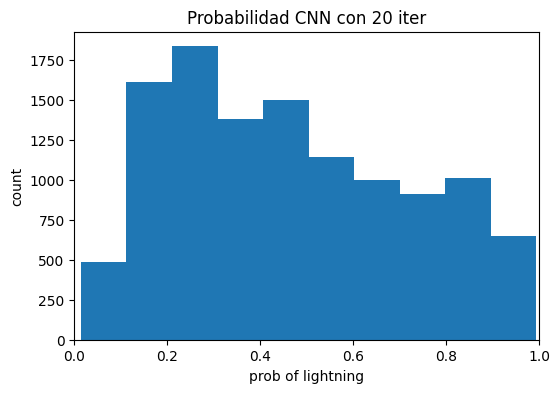

In [9]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.figure(figsize=(6,4))
plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])
plt.title('Probabilidad CNN con 20 iter')

De forma visual podemos ver que la gran mayoria se situan en un 0 o 1 de probabilidad de rayo, veamoslo de forma numerica:

In [10]:
loss, accuracy = model.evaluate(ds_val)
print(f"Accuracy en validación: {accuracy:.4f}")


361/361 [==============================] - 0s 1ms/step - loss: 0.6323 - accuracy: 0.6816
Accuracy en validación: 0.6816


Veamos la salida visual de la capa de convolucion:

361/361 [==============================] - 0s 987us/step


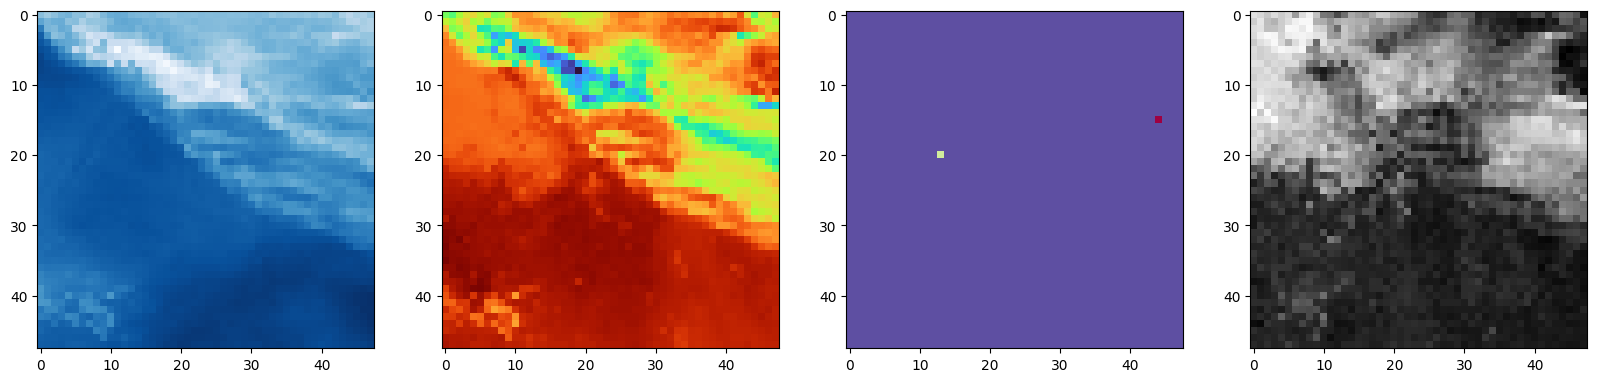

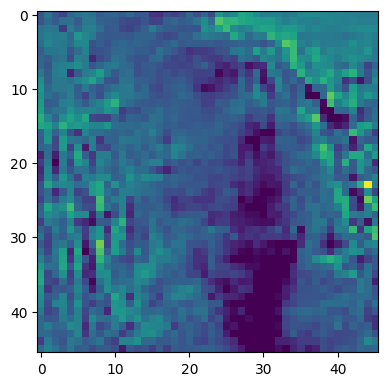

In [11]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(ds_val)

#get the features for example 12 in this batch 
one_example_features = batch[0][5]
#get the label for that same example 
one_example_label = batch[1][5]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label


plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[5])

Añadamosle una ANN a la CNN:

In [12]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(ds_train.element_spec[0].shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
    
        #add two dense layers (which is the same as an ANN)
        tf.keras.layers.Dense(16,activation='relu'), 
        tf.keras.layers.Dense(32,activation='relu'),
        
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 46, 46, 1)         37        
                                                                 
 flatten_1 (Flatten)         (None, 2116)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                33872     
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,486
Trainable params: 34,486
Non-trainable params: 0
_________________________________________________________________


Entrenamos este nuevo modelo:

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),metrics='accuracy')

history = model.fit(ds_train,validation_data=ds_val,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.3100 - accuracy: 0.8691 - val_loss: 0.2823 - val_accuracy: 0.8793
Epoch 2/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.2299 - accuracy: 0.9098 - val_loss: 0.2805 - val_accuracy: 0.8785
Epoch 3/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.1987 - accuracy: 0.9263 - val_loss: 0.2812 - val_accuracy: 0.8793
Epoch 4/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.1743 - accuracy: 0.9373 - val_loss: 0.3019 - val_accuracy: 0.8721
Epoch 5/10
1875/1875 [==============================] - 74s 40ms/step - loss: 0.1556 - accuracy: 0.9446 - val_loss: 0.3248 - val_accuracy: 0.8693
Epoch 6/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.1398 - accuracy: 0.9514 - val_loss: 0.3706 - val_accuracy: 0.8585
Epoch 7/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.1274 - accuracy: 0.9570 - val_loss: 0.4073 -

Vemos señales de overfitting:

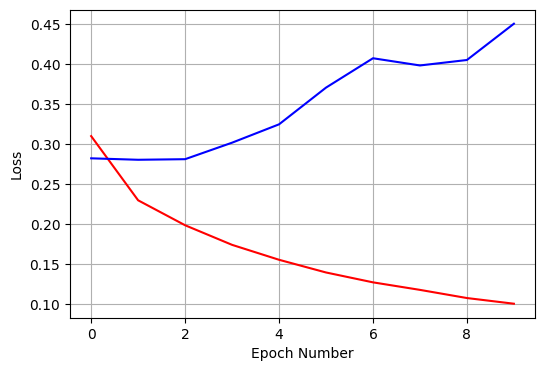

In [14]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

Esto da clara señales de overfitting, así que para arreglarlo vamos a realizar un dropout, es decir, vamos a escoger de forma aleatorio neuronales para que se encendan/apaguen para que la red no pueda memorizar ejemplos:

In [15]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(ds_train.element_spec[0].shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
    
        #add dense layer 
        tf.keras.layers.Dense(16,activation='relu'),
        #add a layer of dropout where 1/3 of the neurons are randomly turned off 
        tf.keras.layers.Dropout(0.33),
        #add another dense layer 
        tf.keras.layers.Dense(32,activation='relu'),
        #add another dropout layer 
        tf.keras.layers.Dropout(0.33),
        
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 1)         37        
                                                                 
 flatten_2 (Flatten)         (None, 2116)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                33872     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),metrics='accuracy')

history = model.fit(ds_train,validation_data=ds_val,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.3737 - accuracy: 0.8376 - val_loss: 0.3071 - val_accuracy: 0.8769
Epoch 2/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.2799 - accuracy: 0.8958 - val_loss: 0.2890 - val_accuracy: 0.8816
Epoch 3/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.2643 - accuracy: 0.9033 - val_loss: 0.2847 - val_accuracy: 0.8777
Epoch 4/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.2593 - accuracy: 0.9047 - val_loss: 0.2758 - val_accuracy: 0.8897
Epoch 5/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.2572 - accuracy: 0.9055 - val_loss: 0.2484 - val_accuracy: 0.8989
Epoch 6/10
1875/1875 [==============================] - 74s 39ms/step - loss: 0.2563 - accuracy: 0.9069 - val_loss: 0.2478 - val_accuracy: 0.9009
Epoch 7/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.2551 - accuracy: 0.9075 - val_loss: 0.2574 -

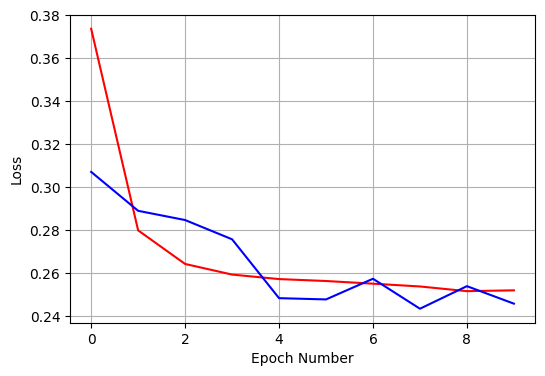

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

En este modelo, ya se ve que no hay signos de sobreajuste, por lo que sacaremos la precisión de este modelo de forma numerica:

In [18]:
loss, accuracy = model.evaluate(ds_val)
print(f"Accuracy en validación: {accuracy:.4f}")


361/361 [==============================] - 1s 2ms/step - loss: 0.2458 - accuracy: 0.9023
Accuracy en validación: 0.9023


Veamos aquí otro ejemplo de salida de la capa de convolucion:

361/361 [==============================] - 0s 870us/step


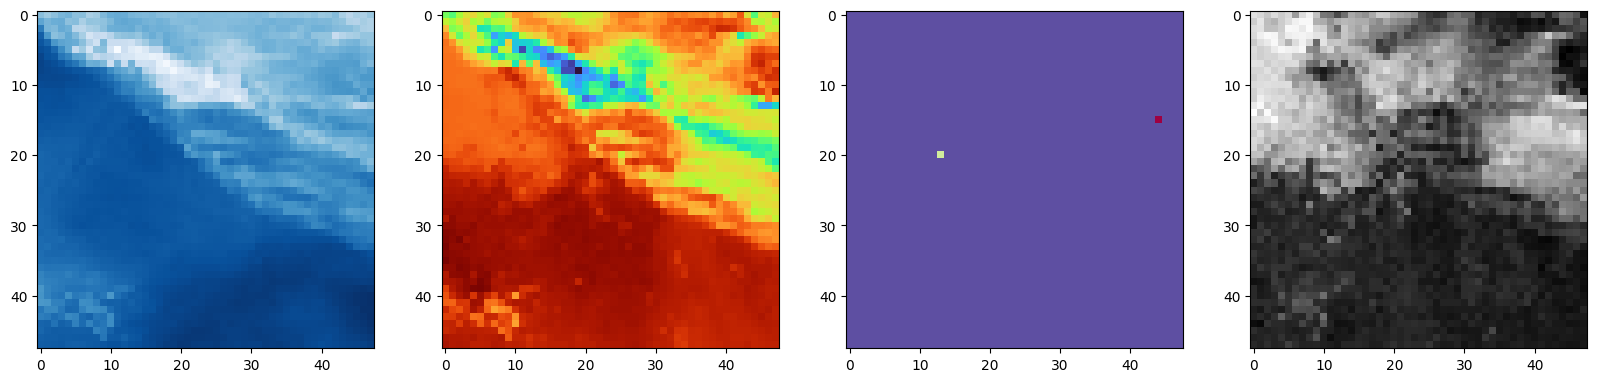

<Figure size 440x500 with 0 Axes>

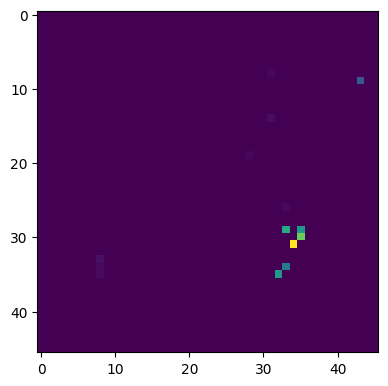

In [19]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d_2')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(ds_val)

#get the features for example 12 in this batch 
one_example_features = batch[0][5]
#get the label for that same example 
one_example_label = batch[1][5]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label


plt.figure(figsize=(4.4,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label


plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[5])

Veamos la salida:

In [20]:
y_v = np.array([])
for _,y in ds_val:
    y_v = np.append(y_v,y)

361/361 [==============================] - 1s 4ms/step


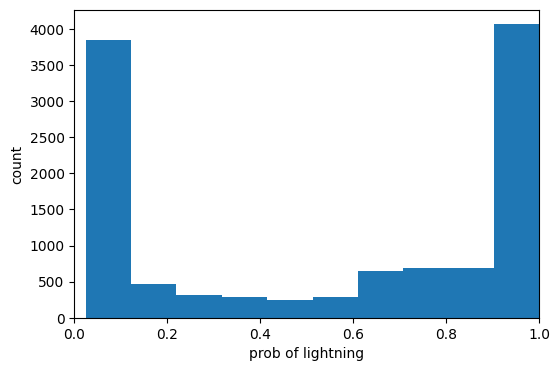

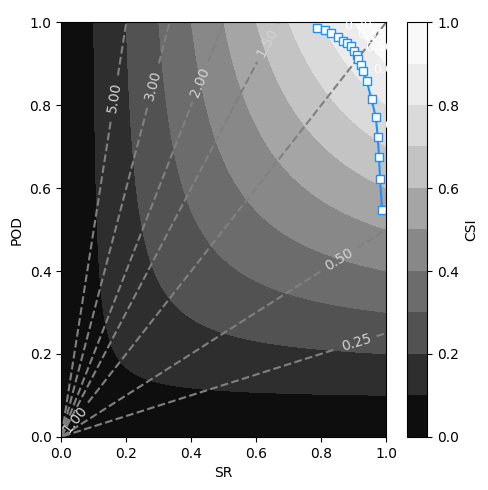

In [21]:
plt.figure(figsize=(6,4))
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    if np.mod(i,3)==0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

plt.tight_layout()

## CNN Regresion:

Hagamos una CNN para regresion, para ello cogemos el dataset:

In [50]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [52]:
ds_train

<xarray.Dataset> Size: 3GB
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 480kB ...
  * n_channel       (n_channel) <U5 80B 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 480kB 2018-08-25T00:15:00 ... ...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 2GB ...
    label_1d_class  (n_samples) int8 60kB ...
    label_1d_reg    (n_samples) int16 120kB ...
    label_2d_class  (n_samples, x, y) int8 138MB ...
    label_2d_reg    (n_samples, x, y) int16 276MB ...

Creamos los datasets, para ello en este caso se escoge label_1d_REG.values:

In [53]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_1d_reg.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_1d_reg.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [54]:
ds_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>

<tf.Tensor: shape=(), dtype=int16, numpy=0>

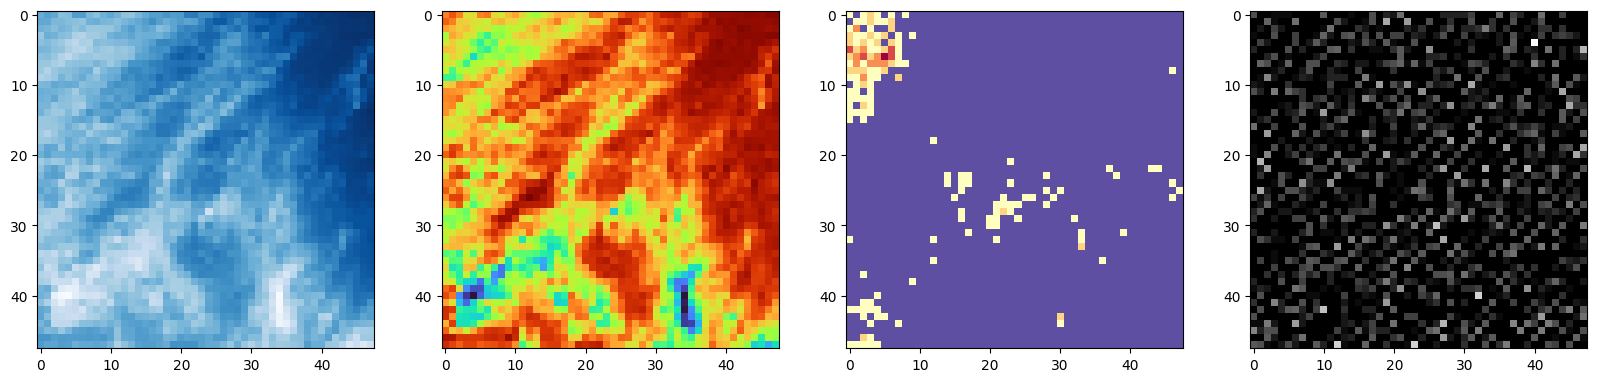

In [57]:
for batch in ds_train:
    break 

#get the features for example 12 in this batch 
one_example_features = batch[0][12]
#get the label for that same example 
one_example_label = batch[1][12]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

Creemos el modelo de CNN, que va a predecir el numero de rayos:

In [62]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo
model = models.Sequential([
    layers.Input(shape=(48, 48, 4)),

    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1)  # Salida continua para regresión
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        1184      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 global_average_pooling2d_1   (None, 128)            

In [63]:
history = model.fit(ds_train, validation_data=ds_val, epochs=30)

Epoch 1/30
1875/1875 [==============================] - 34s 18ms/step - loss: 15248.2676 - root_mean_squared_error: 123.4839 - val_loss: 15752.9336 - val_root_mean_squared_error: 125.5107
Epoch 2/30
1875/1875 [==============================] - 34s 18ms/step - loss: 13907.4902 - root_mean_squared_error: 117.9300 - val_loss: 11584.9727 - val_root_mean_squared_error: 107.6335
Epoch 3/30
1875/1875 [==============================] - 33s 18ms/step - loss: 13306.1494 - root_mean_squared_error: 115.3523 - val_loss: 10170.0977 - val_root_mean_squared_error: 100.8469
Epoch 4/30
1875/1875 [==============================] - 33s 18ms/step - loss: 12227.3604 - root_mean_squared_error: 110.5774 - val_loss: 11225.5713 - val_root_mean_squared_error: 105.9508
Epoch 5/30
1875/1875 [==============================] - 32s 17ms/step - loss: 11090.2588 - root_mean_squared_error: 105.3103 - val_loss: 9767.7754 - val_root_mean_squared_error: 98.8321
Epoch 6/30
1875/1875 [==============================] - 33s 18

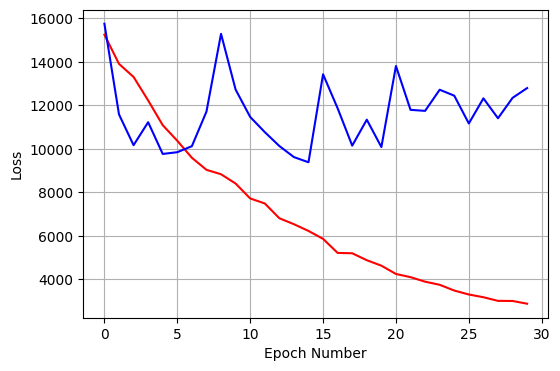

In [64]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

Esto muestra claros signos de sobreajuste, para ello tratemos de solucionarlo

In [65]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = models.Sequential([
    layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(48, 48, 4)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.GlobalAveragePooling2D(),  # Reemplaza Flatten para mejor generalización

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1)  # Salida para regresión (sin activación)
])

# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
1875/1875 [==============================] - 25s 13ms/step - loss: 16869.4551 - root_mean_squared_error: 129.8819 - val_loss: 18853.5801 - val_root_mean_squared_error: 137.3076
Epoch 2/50
1875/1875 [==============================] - 25s 13ms/step - loss: 15400.8672 - root_mean_squared_error: 124.0992 - val_loss: 12851.0039 - val_root_mean_squared_error: 113.3606
Epoch 3/50
1875/1875 [==============================] - 24s 13ms/step - loss: 15158.6279 - root_mean_squared_error: 123.1185 - val_loss: 14779.4531 - val_root_mean_squared_error: 121.5684
Epoch 4/50
1875/1875 [==============================] - 25s 13ms/step - loss: 14618.0947 - root_mean_squared_error: 120.9025 - val_loss: 13482.0410 - val_root_mean_squared_error: 116.1086
Epoch 5/50
1875/1875 [==============================] - 25s 13ms/step - loss: 13576.0430 - root_mean_squared_error: 116.5121 - val_loss: 11264.1016 - val_root_mean_squared_error: 106.1272
Epoch 6/50
1875/1875 [==============================] - 25s 

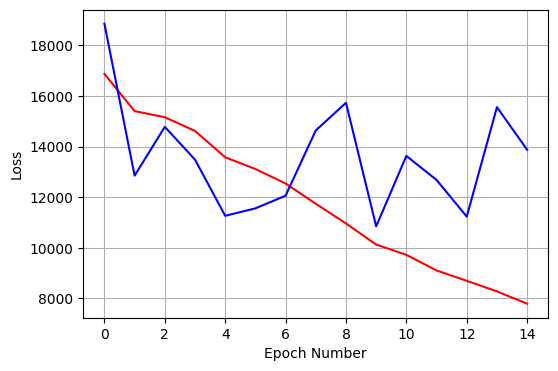

In [66]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

De la misma forma, sigue habiendo signos de sobreajuste, por lo que realizamos un modelo mayor al previo. Asimismo se le añade a todas las capas de convolucion dropout y normalizacion:

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models

model = tf.keras.Sequential([
    # Bloque 1
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                  input_shape=(48, 48, 4), kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),

    # Bloque 2
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.4),

    # Bloque 3
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.5),

    # Paso a vector
    layers.Flatten(),

    # Capa densa intermedia
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),

    # Capa de salida: regresión
    layers.Dense(1)
])

# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        1184      
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 24, 24, 64)     

In [68]:
# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
1875/1875 [==============================] - 55s 29ms/step - loss: 15816.1123 - root_mean_squared_error: 125.7560 - val_loss: 14946.9414 - val_root_mean_squared_error: 122.2479
Epoch 2/50
1875/1875 [==============================] - 55s 29ms/step - loss: 13793.3799 - root_mean_squared_error: 117.4308 - val_loss: 13466.8740 - val_root_mean_squared_error: 116.0272
Epoch 3/50
1875/1875 [==============================] - 55s 29ms/step - loss: 11621.8047 - root_mean_squared_error: 107.7769 - val_loss: 12265.8867 - val_root_mean_squared_error: 110.7182
Epoch 4/50
1875/1875 [==============================] - 55s 29ms/step - loss: 10090.0742 - root_mean_squared_error: 100.4063 - val_loss: 16190.1064 - val_root_mean_squared_error: 127.2012
Epoch 5/50
1875/1875 [==============================] - 55s 29ms/step - loss: 8977.7324 - root_mean_squared_error: 94.6920 - val_loss: 15273.8838 - val_root_mean_squared_error: 123.5376
Epoch 6/50
1875/1875 [==============================] - 56s 30

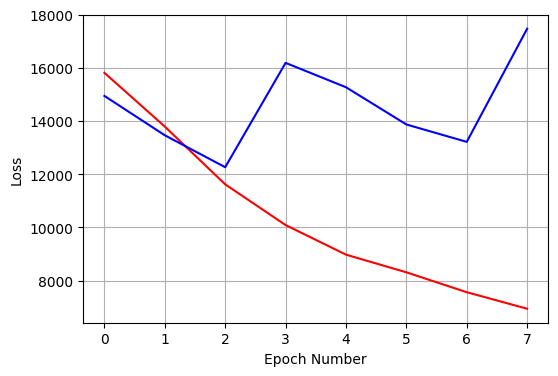

In [69]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

Sigue dando claras muestras de sobreajuste, por lo que en vez de aplanar el vector, realizamos un AveragePooling y se le añade un Early_Stop para evitar el sobreajuste al vigilar la métrica de pérdida y poner ciertos parametros de tolerancia:

In [70]:
from tensorflow.keras import layers, regularizers, models

model = models.Sequential([
    # Bloque 1
    layers.Conv2D(32, 3, activation='relu', padding='same',
                  input_shape=(48, 48, 4), kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),

    # Bloque 2
    layers.Conv2D(64, 3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),

    # Bloque 3
    layers.Conv2D(128, 3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.4),

    # Capa Global Average (menos parámetros que flatten)
    layers.GlobalAveragePooling2D(),

    # Capa densa final
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [93]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        1184      
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_22 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 64)     

In [71]:
# EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
1875/1875 [==============================] - 47s 25ms/step - loss: 22402.5039 - root_mean_squared_error: 149.6746 - val_loss: 15576.7666 - val_root_mean_squared_error: 124.8068
Epoch 2/50
1875/1875 [==============================] - 45s 24ms/step - loss: 15364.8691 - root_mean_squared_error: 123.9550 - val_loss: 12863.5322 - val_root_mean_squared_error: 113.4174
Epoch 3/50
1875/1875 [==============================] - 45s 24ms/step - loss: 14645.1729 - root_mean_squared_error: 121.0171 - val_loss: 13122.9883 - val_root_mean_squared_error: 114.5555
Epoch 4/50
1875/1875 [==============================] - 46s 25ms/step - loss: 14418.9395 - root_mean_squared_error: 120.0788 - val_loss: 12526.9102 - val_root_mean_squared_error: 111.9236
Epoch 5/50
1875/1875 [==============================] - 45s 24ms/step - loss: 14316.1631 - root_mean_squared_error: 119.6500 - val_loss: 12122.9668 - val_root_mean_squared_error: 110.1042
Epoch 6/50
1875/1875 [==============================] - 45s 

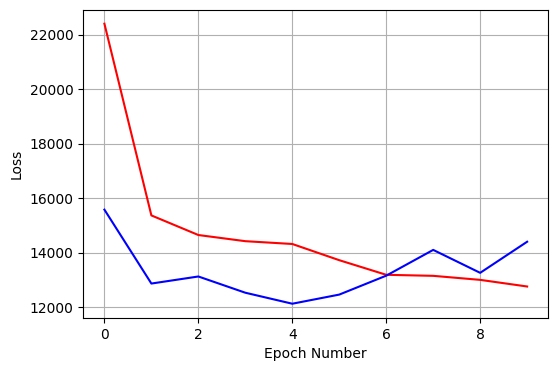

In [72]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

Esta vez podemos ver signos de sobreajuste a partir de la sexta iteración pero gracias al EarlyStopping, nuestro modelo se ha quedado en la quinta iteración. Procedamos a calcular los errores de forma numérica:

In [75]:
import numpy as np

# Obtener predicciones del modelo sobre el conjunto de validación
y_pred = model.predict(ds_val)
# Obtener valores reales (etiquetas) del dataset
y_true = np.concatenate([y for x, y in ds_val], axis=0)


361/361 [==============================] - 2s 6ms/step


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
abs(np.mean(y_pred - y_true))

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"bias: {bias:.4f}")


RMSE: 110.10
MAE: 50.25
R²: 0.6626
bias: 20.5387


## U-Net:

Esta vez el dataset utilizado, será el mismo del apartado de CNN:

In [4]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

Ahora creamos el dataset que se le suministrará a la U-Net, a dferencia de antes se usará label_2d.

In [5]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

Veamos un ejemplo de loq ue trae este dataset:

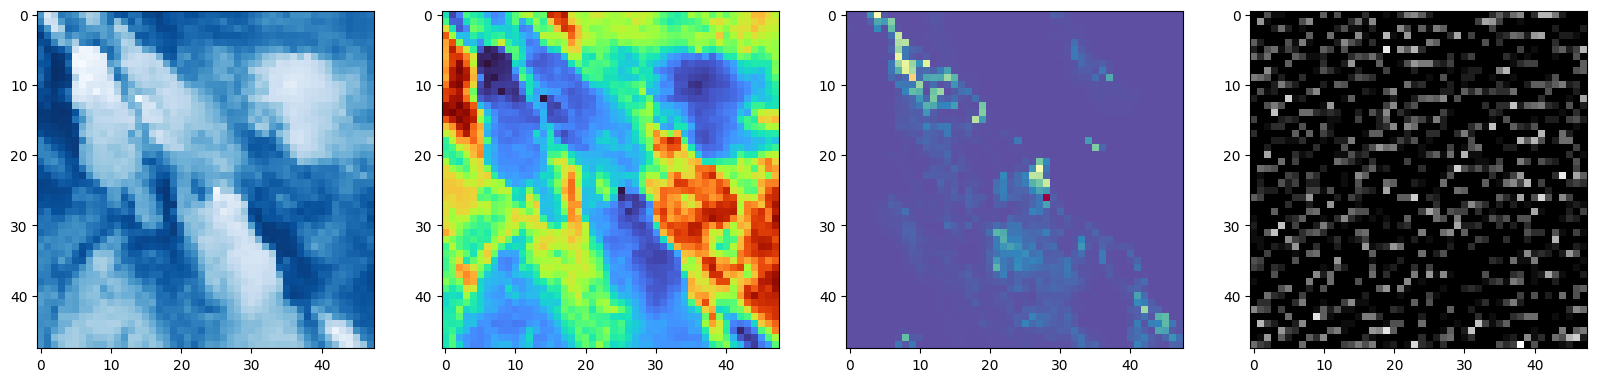

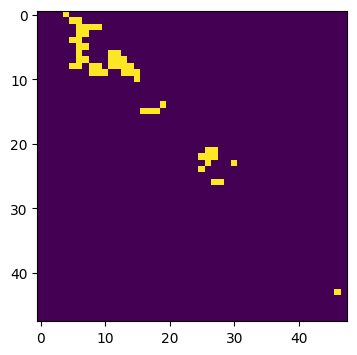

In [4]:
for batch in ds_train:
    break 

#get the features for example 29 in this batch 
one_example_features = batch[0][29]
#get the label for that same example 
one_example_label = batch[1][29]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

fig,axes = plt.subplots(1,1,figsize=(4,5))
axes.imshow(one_example_label)

Las primeras 4 imagenes son los mapa de Vapor de Agua, Infrarrojos, Radar y Visible, asimismo la segunda fila nos da un mapa de las ubicaciones de los rayos.

Una vez ya vistos que contiene nuestro conjunto de datos, procedamos con las construccion de la U-Net:

In [5]:
model = models.unet_2d([48,48,4],[2,4],1,stack_num_down=1,stack_num_up=1,output_activation='Sigmoid',weights=None)

In [6]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 unet_down0_0 (Conv2D)          (None, 48, 48, 2)    74          ['input_1[0][0]']                
                                                                                                  
 unet_down0_0_activation (ReLU)  (None, 48, 48, 2)   0           ['unet_down0_0[0][0]']           
                                                                                                  
 unet_down1_encode_maxpool (Max  (None, 24, 24, 2)   0           ['unet_down0_0_activation[0][0]']
 Pooling2D)                                                                              

Entrenamos este modelo:

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics='accuracy')

history = model.fit(ds_train,validation_data=ds_val,epochs=5)

Epoch 1/5
938/938 [==============================] - 185s 197ms/step - loss: 0.1104 - accuracy: 0.9876 - val_loss: 0.0479 - val_accuracy: 0.9901
Epoch 2/5
938/938 [==============================] - 184s 196ms/step - loss: 0.0340 - accuracy: 0.9909 - val_loss: 0.0338 - val_accuracy: 0.9901
Epoch 3/5
938/938 [==============================] - 180s 192ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.0311 - val_accuracy: 0.9901
Epoch 4/5
938/938 [==============================] - 182s 194ms/step - loss: 0.0266 - accuracy: 0.9910 - val_loss: 0.0292 - val_accuracy: 0.9908
Epoch 5/5
938/938 [==============================] - 182s 194ms/step - loss: 0.0255 - accuracy: 0.9916 - val_loss: 0.0284 - val_accuracy: 0.9911


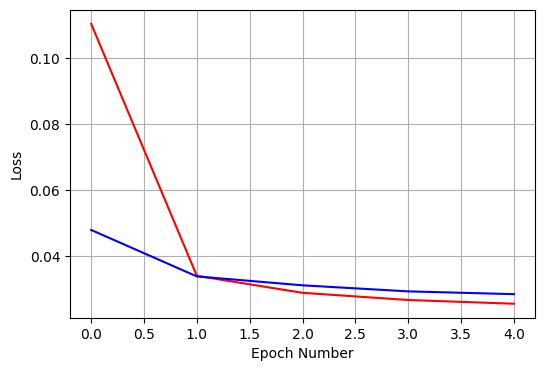

In [8]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

No da signos de sobreajuste, veamos el resultado de las predicciones:

181/181 [==============================] - 1s 4ms/step


(0.0, 1.0)

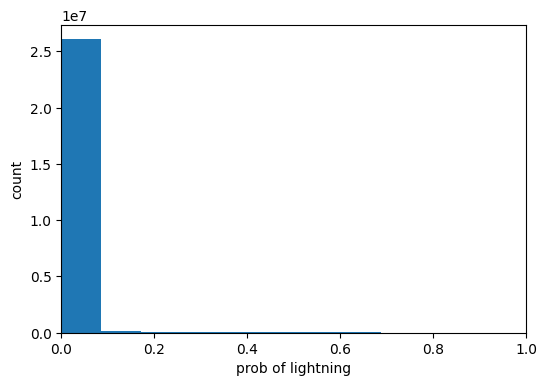

In [33]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.figure(figsize=(6,4))
plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


In [40]:
for batch in ds_val:
    break 

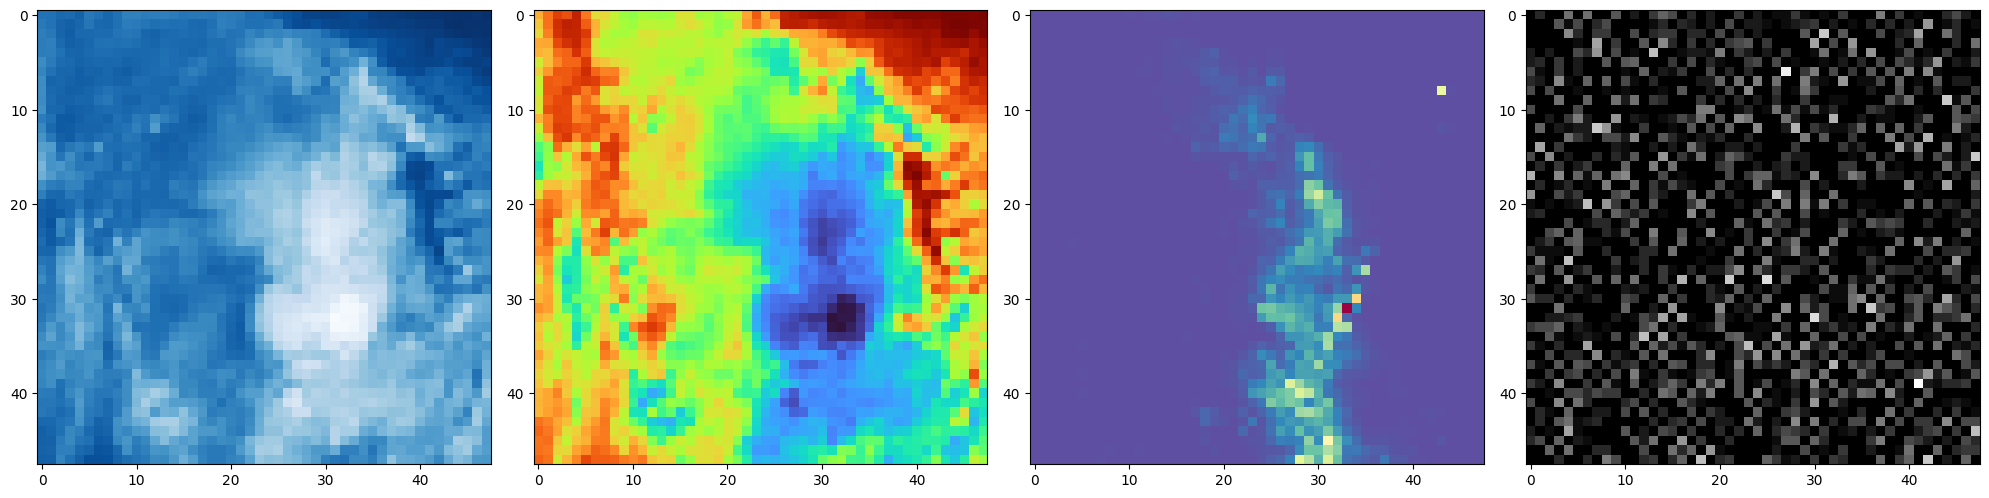

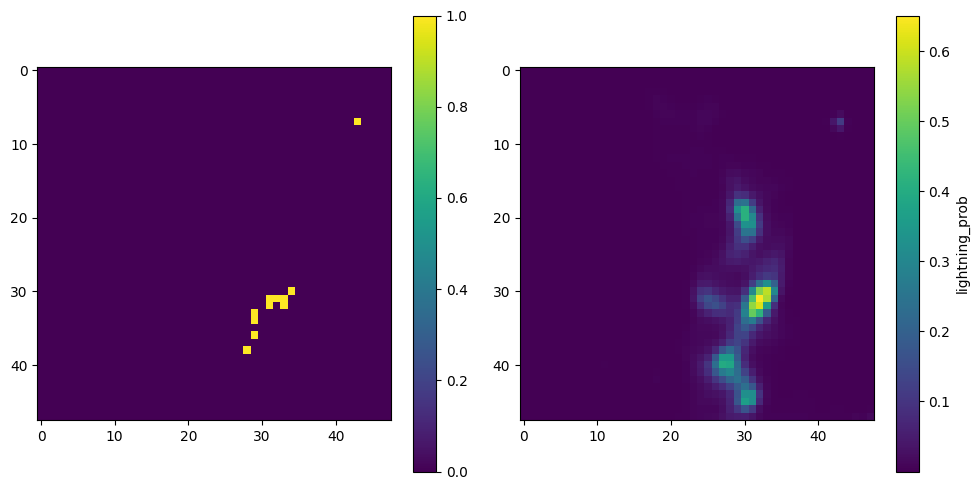

In [41]:
#get the features for example 3 in this batch 
one_example_features = batch[0][2]
#get the label for that same example 
one_example_label = batch[1][2]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[2])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

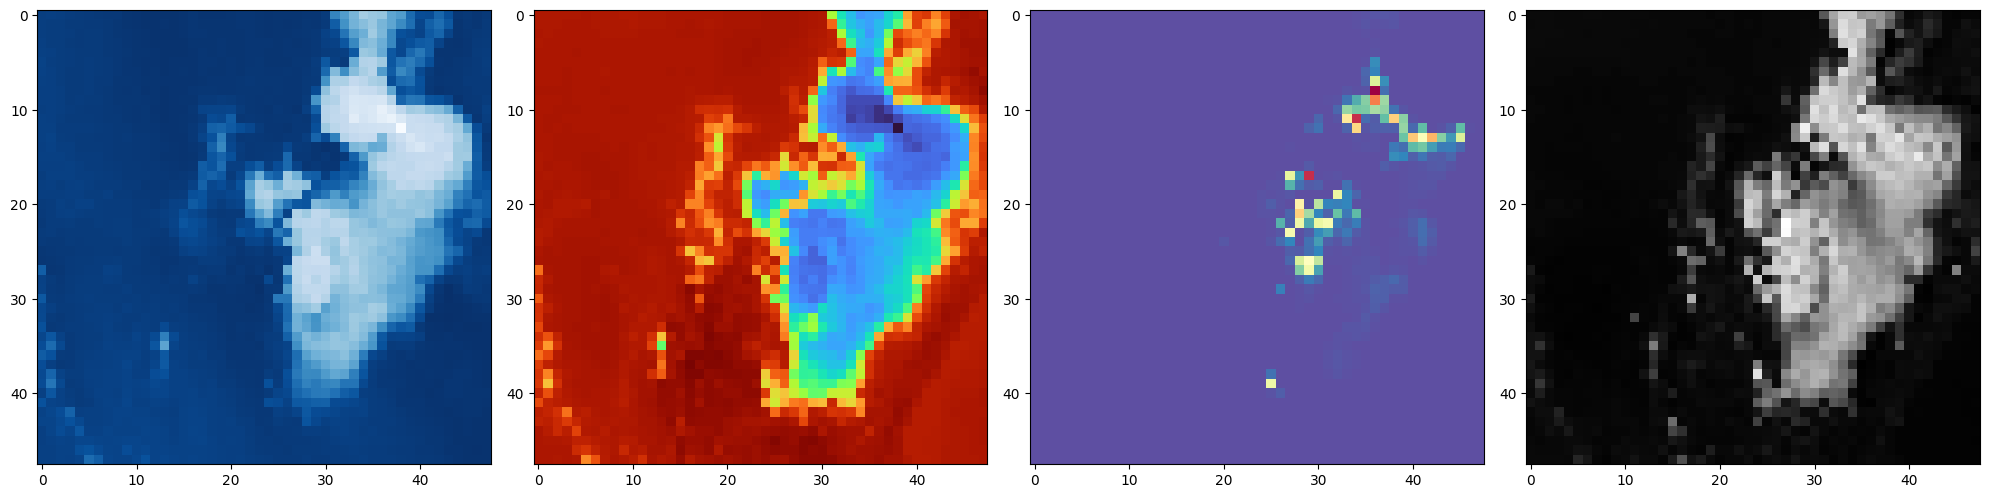

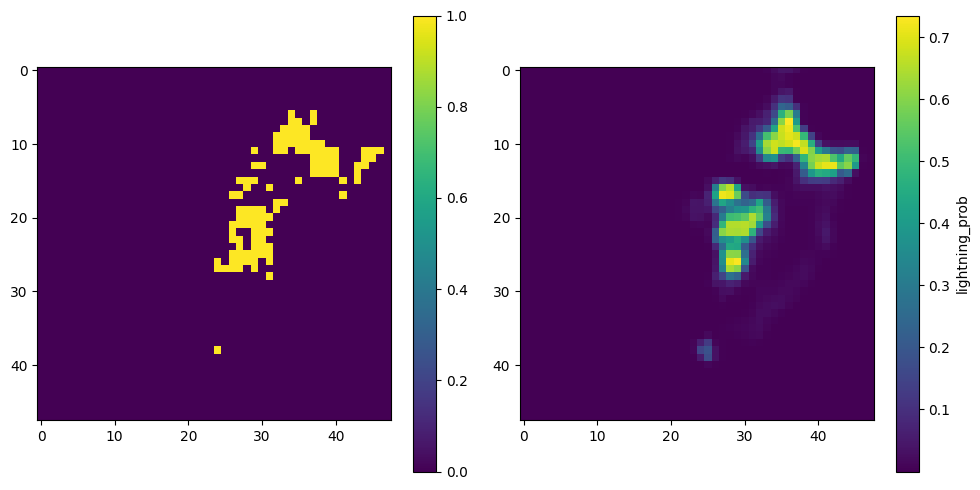

In [48]:
#get the features for example 26 in this batch 
one_example_features = batch[0][25]
#get the label for that same example 
one_example_label = batch[1][25]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[25])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

De forma numerica, la precisión del modelo viene dada por:

In [52]:
loss, accuracy = model.evaluate(ds_val)
print(f"Pixel-wise accuracy en validación: {accuracy:.4f}")

181/181 [==============================] - 1s 4ms/step - loss: 0.0284 - accuracy: 0.9911
Pixel-wise accuracy en validación: 0.9911


Essto nos dice que es nuestro mejor modelo hasta la fecha, no obstante al realizarse una aproximacion pixel al pixel no resulta en una comparativa justa con el resto de modelos previos. Por ello se va a realizar otro modelo de U-Net cuyo dato de entrada sea del formato binario.

In [24]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [25]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [29]:
y_true = np.concatenate([y for x, y in ds_val], axis=0)
y_true[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [30]:
y_true.shape

(11527, 48, 48)

Vamos a tomar como salida en vez de una matriz, el maximo de la matriz, si esta contiene un uno significa que hay algún rayo en la imagen y sino, entonces se tomará cero.

In [35]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [36]:
# Crear nuevas etiquetas escalares por muestra (máximo valor de cada matriz)
y_train_scalar = ds_train.label_2d_class.values.max(axis=(1, 2), keepdims=True)  # shape: (n_samples, 1)
y_val_scalar   = ds_val.label_2d_class.values.max(axis=(1, 2), keepdims=True)    # shape: (n_samples, 1)

# Crear datasets de entrenamiento y validación
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values, y_train_scalar))
ds_val   = tf.data.Dataset.from_tensor_slices((ds_val.features.values, y_val_scalar))

# Semilla para reproducibilidad
tf.random.set_seed(42)

# Mezclamos solo el conjunto de entrenamiento
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

# Agrupamos en batches
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val   = ds_val.batch(batch_size)


In [37]:
y_true = np.concatenate([y for x, y in ds_val], axis=0)
y_true

array([[[1]],

       [[1]],

       [[1]],

       ...,

       [[0]],

       [[0]],

       [[0]]], dtype=int8)

In [38]:
ds_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.int8, name=None))>

Luego nuestros valores reales ahora son binarios y no una matriz 48x48. Procedemos a entrenar el mismo modelo previo:

In [39]:
model = models.unet_2d([48,48,4],[2,4],1,stack_num_down=1,stack_num_up=1,output_activation='Sigmoid',weights=None)
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 unet_down0_0 (Conv2D)          (None, 48, 48, 2)    74          ['input_3[0][0]']                
                                                                                                  
 unet_down0_0_activation (ReLU)  (None, 48, 48, 2)   0           ['unet_down0_0[0][0]']           
                                                                                                  
 unet_down1_encode_maxpool (Max  (None, 24, 24, 2)   0           ['unet_down0_0_activation[0][0]']
 Pooling2D)                                                                              

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics='accuracy')

history = model.fit(ds_train,validation_data=ds_val,epochs=5)

Epoch 1/5
938/938 [==============================] - 203s 215ms/step - loss: 0.5946 - accuracy: 0.6832 - val_loss: 0.5645 - val_accuracy: 0.6938
Epoch 2/5
938/938 [==============================] - 201s 214ms/step - loss: 0.5478 - accuracy: 0.7227 - val_loss: 0.5319 - val_accuracy: 0.7196
Epoch 3/5
938/938 [==============================] - 199s 212ms/step - loss: 0.5245 - accuracy: 0.7376 - val_loss: 0.5220 - val_accuracy: 0.7283
Epoch 4/5
938/938 [==============================] - 200s 213ms/step - loss: 0.5156 - accuracy: 0.7425 - val_loss: 0.5212 - val_accuracy: 0.7273
Epoch 5/5
938/938 [==============================] - 198s 211ms/step - loss: 0.5118 - accuracy: 0.7443 - val_loss: 0.5127 - val_accuracy: 0.7357


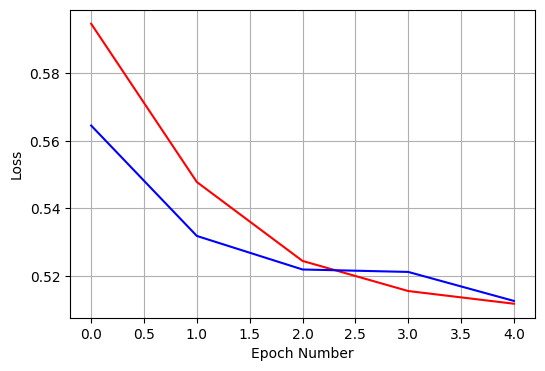

In [41]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

In [42]:
loss, accuracy = model.evaluate(ds_val)
print(f"Precisión en validación: {accuracy:.4f}")

181/181 [==============================] - 1s 5ms/step - loss: 0.5127 - accuracy: 0.7357
Precisión en validación: 0.7357


## U-Net Regresion:

Creamos el dataset de regresion:

In [6]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [7]:
ds_train

<xarray.Dataset> Size: 3GB
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 480kB ...
  * n_channel       (n_channel) <U5 80B 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 480kB 2018-08-25T00:15:00 ... ...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 2GB ...
    label_1d_class  (n_samples) int8 60kB ...
    label_1d_reg    (n_samples) int16 120kB ...
    label_2d_class  (n_samples, x, y) int8 138MB ...
    label_2d_reg    (n_samples, x, y) int16 276MB ...

Se escoge label_2d_REG para realizar la regresión

In [8]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_reg.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_reg.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

Veamos un ejemplo de lo que contiene el dataset:

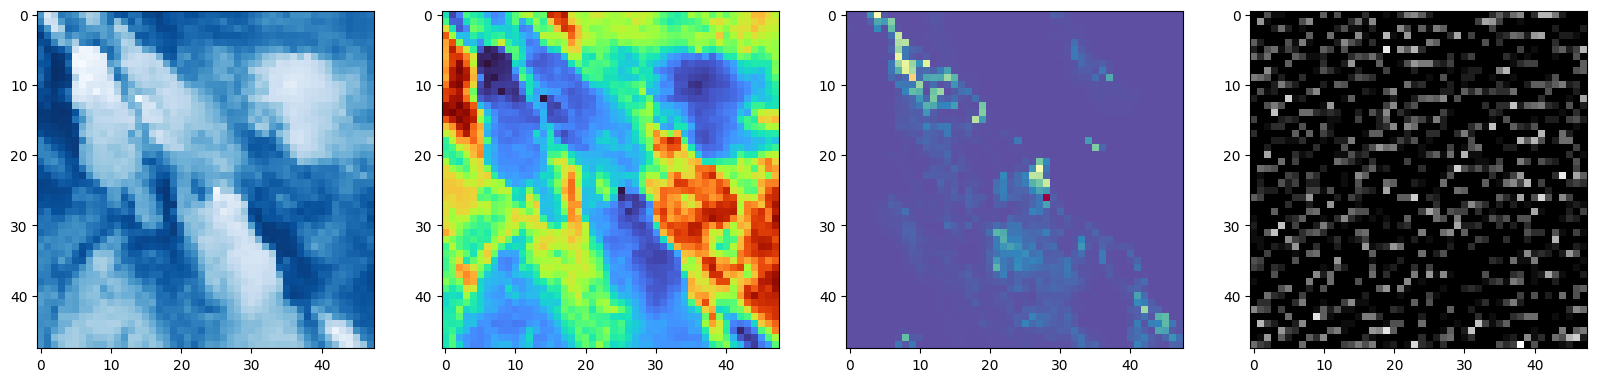

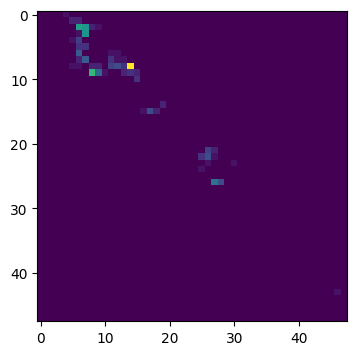

In [17]:
for batch in ds_train:
    break 

#get the features for example 29 in this batch 
one_example_features = batch[0][29]
#get the label for that same example 
one_example_label = batch[1][29]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

fig,axes = plt.subplots(1,1,figsize=(4,5))
axes.imshow(one_example_label)


Veamos un ejemplo de la salida que buscamos al realizar la predicción:

In [18]:
print(one_example_label)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(48, 48), dtype=int16)


Este modelo va a actuar sobre cada pixel de forma individual, es decir, va a predercir el numero de rayos por pixel, por lo que en realidad no es muy comparable a los anteriores. No obstante creemos el modelo y veamos su rendimiento:

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU

model = Sequential()

# --- Encoder (3 bloques + bottleneck = profundidad 4) ---
model.add(Conv2D(32, (7, 7), padding='same', input_shape=(48, 48, 4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 24x24

model.add(Conv2D(64, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 12x12

model.add(Conv2D(128, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 6x6

# --- Bottleneck ---
model.add(Conv2D(256, (7, 7), padding='same'))  # Bottleneck de 256
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# --- Decoder ---
model.add(UpSampling2D((2, 2)))  # 12x12
model.add(Conv2D(128, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

model.add(UpSampling2D((2, 2)))  # 24x24
model.add(Conv2D(64, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

model.add(UpSampling2D((2, 2)))  # 48x48
model.add(Conv2D(32, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# --- Output layer for regression ---
model.add(Conv2D(1, (1, 1), activation='linear'))

# --- Compile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        6304      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        100416    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

Se realiza el entrenamiento de la CNN:

In [10]:
history = model.fit(ds_train, validation_data=ds_val, epochs=4)

Epoch 1/4
938/938 [==============================] - 714s 760ms/step - loss: 0.0395 - root_mean_squared_error: 0.6398 - val_loss: 0.0403 - val_root_mean_squared_error: 0.7037
Epoch 2/4
938/938 [==============================] - 704s 750ms/step - loss: 0.0326 - root_mean_squared_error: 0.6383 - val_loss: 0.0408 - val_root_mean_squared_error: 0.7045
Epoch 3/4
938/938 [==============================] - 713s 760ms/step - loss: 0.0321 - root_mean_squared_error: 0.6383 - val_loss: 0.0383 - val_root_mean_squared_error: 0.7046
Epoch 4/4
938/938 [==============================] - 709s 756ms/step - loss: 0.0320 - root_mean_squared_error: 0.6383 - val_loss: 0.0384 - val_root_mean_squared_error: 0.7046


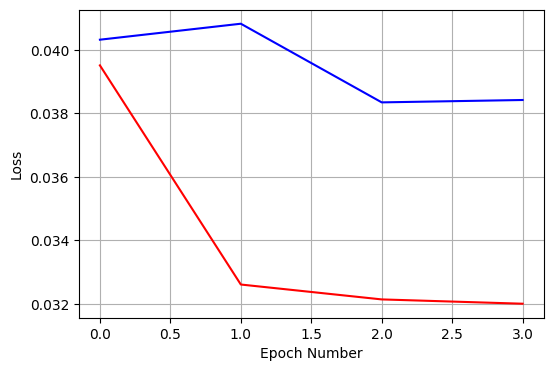

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

En realidad no hay sobreajuste ya que la diferencia es ínfima, veamos un ejemplo de las predicciones hechas por el modelo:

In [15]:
y_pred = model.predict(ds_val)

181/181 [==============================] - 39s 215ms/step


In [17]:
for batch in ds_train:
    break 

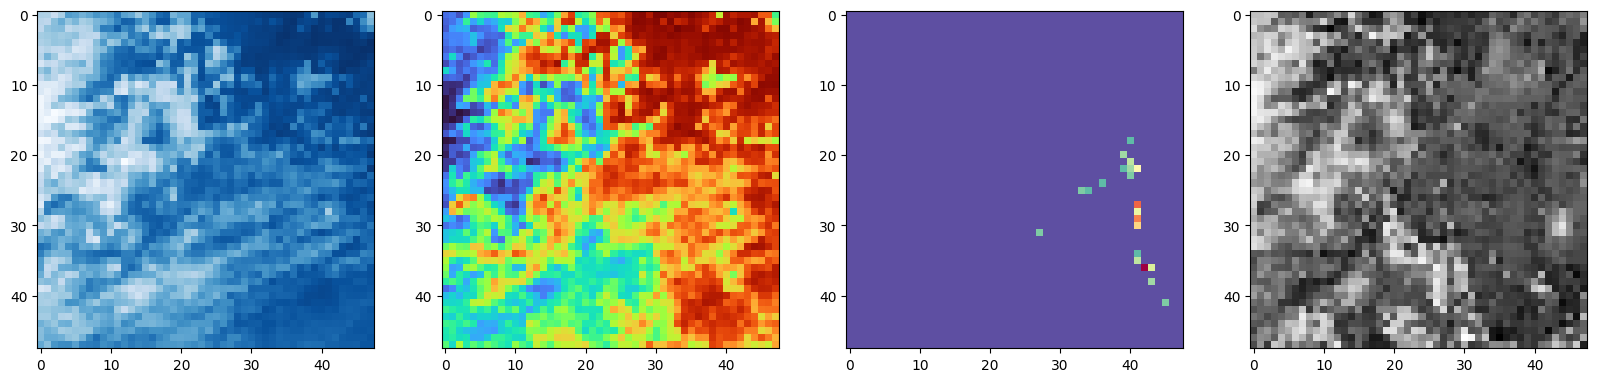

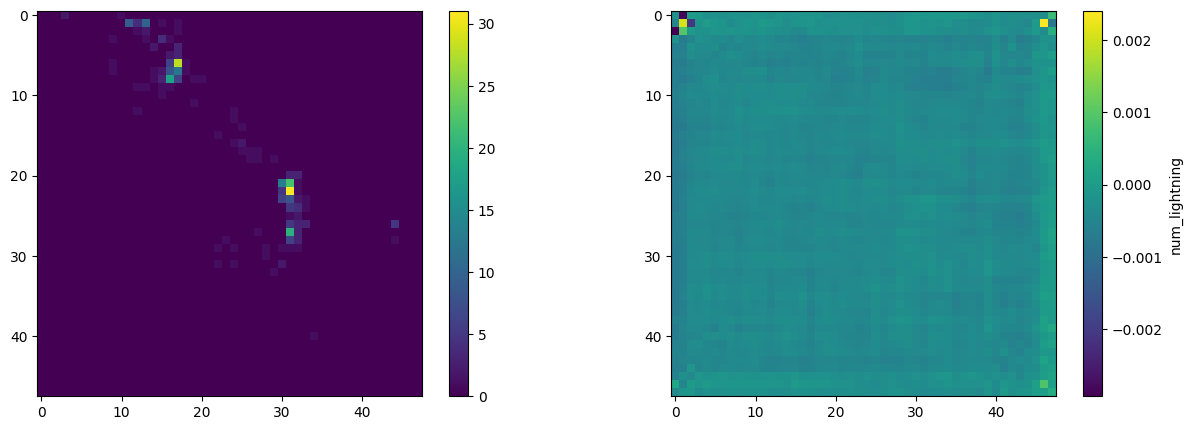

In [29]:
#get the features for example 29 in this batch 
one_example_features = batch[0][5]
#get the label for that same example 
one_example_label = batch[1][7]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

fig,axes = plt.subplots(1,2,figsize=(15,5))
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_pred[11])
plt.colorbar(pm,ax=axes[1],label='num_lightning')

Esto sucede ya que el numero de rayos en general en las imágenes es muy bajo y son sucesos raros. Así que nos aproxima todo el resto de probabilidades de que haya rayos en ese pixel como 0

(0.0, 1.0)

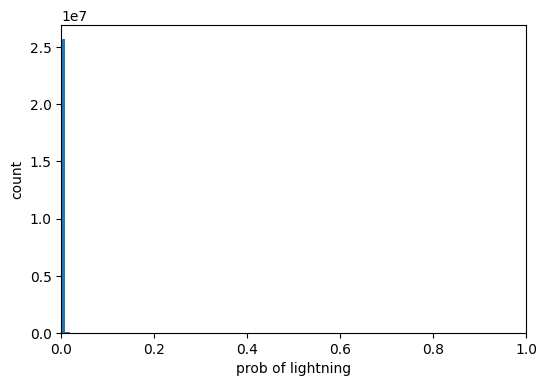

In [36]:
plt.figure(figsize=(6,4))
plt.hist(y_pred.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


Calculemos el error de forma numérico:

In [12]:
# Predicciones:
y_pred = model.predict(ds_val)
# Valores reales:
y_true = np.concatenate([y for x, y in ds_val], axis=0)

181/181 [==============================] - 38s 209ms/step


Veamos la dimension de salida de cada una de las matrices de pixeles de cada una:

In [47]:
y_pred.shape

(11527, 48, 48, 1)

In [48]:
y_true.shape

(11527, 48, 48)

Como tienen dimensión distinta, realizamos este if para cambiarlas (esto es de forma generalizada si no supiesesmos cual de ambas tiene una dimensión menor, en este caso se sabe que y_true es la de menor)

In [49]:
if y_pred.ndim == 3:  # e.g. (11527, 48, 48)
    y_pred = tf.expand_dims(y_pred, axis=-1)

if y_true.ndim == 3:
    y_true = tf.expand_dims(y_true, axis=-1)

In [50]:
y_pred.shape

(11527, 48, 48, 1)

In [51]:
y_true.shape

TensorShape([11527, 48, 48, 1])

Una vez ya arreglados, realizamos las metricas de error, al ser matrices usamos las métricas implementadas en keras:

In [52]:
mae_total = tf.keras.losses.MeanAbsoluteError()
rmse_total = tf.keras.metrics.RootMeanSquaredError()

mae = mae_total(y_true, y_pred).numpy()
rmse = rmse_total(y_true, y_pred).numpy()

print(f"MAE total: {mae:.4f}")
print(f"RMSE total: {rmse:.4f}")


MAE total: 0.0392
RMSE total: 0.7047


Las metricas de R2 y Bias no están definidas en keras, por lo que se definen de forma manual en np:

In [61]:
def r2_score_np(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    ss_res = np.sum(np.square(y_true - y_pred))
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (ss_res / (ss_tot + 1e-7))  # pequeña constante para evitar división por 0

def bias_np(y_true, y_pred):
    return np.mean(y_pred.flatten() - y_true.flatten())

y_true_np = y_true.numpy() #y_true es un elto de tensorflow hay que pasarlo a numpy para realizar flatten()

r2 = r2_score_np(y_true_np, y_pred)
bias = abs(bias_np(y_true_np, y_pred))

print(f"R²:   {r2:.4f}")
print(f"Bias: {bias:.4f}")


R²:   -0.0028
Bias: -0.0369


Como se puede ver, las metricas de error de este modelo son muy pequeñas, esto es debido a como hemos menciado antes, que las predicciones se realizan pixel a pixel, para poder hacer algo más equitativo a la hora de ralizar la comparacion, realicemos un modelo de CNN que predizca el numero de rayos totales sobre la imagen, es decir cambiemos nuestros objetivos de prediccion de la matriz a la suma de todos los componentes de la matriz:

In [62]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [63]:
ds_train

<xarray.Dataset> Size: 3GB
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 480kB ...
  * n_channel       (n_channel) <U5 80B 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 480kB 2018-08-25T00:15:00 ... ...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 2GB ...
    label_1d_class  (n_samples) int8 60kB ...
    label_1d_reg    (n_samples) int16 120kB ...
    label_2d_class  (n_samples, x, y) int8 138MB ...
    label_2d_reg    (n_samples, x, y) int16 276MB ...

In [64]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_reg.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_reg.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

Veamos la forma actual de nuestros datos objetivos actuales 

In [67]:
y_true = np.concatenate([y for x, y in ds_train], axis=0)
y_true

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [68]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [70]:
# Crear nuevas etiquetas escalar por muestra (suma total de cada matriz)
y_train_scalar = ds_train.label_2d_reg.values.sum(axis=(1, 2), keepdims=True)  # shape: (n_samples, 1)
y_val_scalar   = ds_val.label_2d_reg.values.sum(axis=(1, 2), keepdims=True)    # shape: (n_samples, 1)

# Dataset de entrenamiento y validación
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values, y_train_scalar))
ds_val  = tf.data.Dataset.from_tensor_slices((ds_val.features.values, y_val_scalar))

tf.random.set_seed(42)

#Mezclamos solo el de entrenamiento
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

Volvamos a comprobarlo

In [71]:
ds_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.int32, name=None))>

Tenemos que la entrada son de la dimension 48x48x4 justo como antes y la salida es un número:

In [72]:
y_true = np.concatenate([y for x, y in ds_train], axis=0)
y_true

array([[[ 37]],

       [[105]],

       [[ 32]],

       ...,

       [[  1]],

       [[  0]],

       [[ 99]]])

Ahora realicemos el modelo anterior con una ligera modificación en la salida, vamos a realizar una operacion de Pooling y vamos a cambiar la dimensión a (1,1) que es nuestro formato de salida:

In [78]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape

model = Sequential()

# --- Encoder (3 bloques + bottleneck = profundidad 4) ---
model.add(Conv2D(32, (7, 7), padding='same', input_shape=(48, 48, 4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 24x24

model.add(Conv2D(64, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 12x12

model.add(Conv2D(128, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 6x6

# --- Bottleneck ---
model.add(Conv2D(256, (7, 7), padding='same'))  # Bottleneck de 256
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# --- Decoder ---
model.add(UpSampling2D((2, 2)))  # 12x12
model.add(Conv2D(128, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

model.add(UpSampling2D((2, 2)))  # 24x24
model.add(Conv2D(64, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

model.add(UpSampling2D((2, 2)))  # 48x48
model.add(Conv2D(32, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# --- Output layer for regression ---
model.add(Conv2D(1, (1, 1), activation='linear'))
model.add(GlobalAveragePooling2D())               
model.add(Reshape((1, 1))) 

# --- Compile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 48, 48, 32)        6304      
                                                                 
 batch_normalization_84 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 24, 24, 64)        100416    
                                                                 
 batch_normalization_85 (Bat  (None, 24, 24, 64)      

Entrenemos el modelo:

In [79]:
history = model.fit(ds_train, validation_data=ds_val, epochs=4)

Epoch 1/4
938/938 [==============================] - 735s 781ms/step - loss: 71.9950 - root_mean_squared_error: 191.2073 - val_loss: 85.7668 - val_root_mean_squared_error: 206.9815
Epoch 2/4
938/938 [==============================] - 719s 766ms/step - loss: 70.9142 - root_mean_squared_error: 190.0182 - val_loss: 84.7324 - val_root_mean_squared_error: 205.7651
Epoch 3/4
938/938 [==============================] - 722s 769ms/step - loss: 69.8056 - root_mean_squared_error: 188.7694 - val_loss: 83.4076 - val_root_mean_squared_error: 204.1146
Epoch 4/4
938/938 [==============================] - 716s 763ms/step - loss: 68.5494 - root_mean_squared_error: 187.2850 - val_loss: 81.5861 - val_root_mean_squared_error: 202.1691


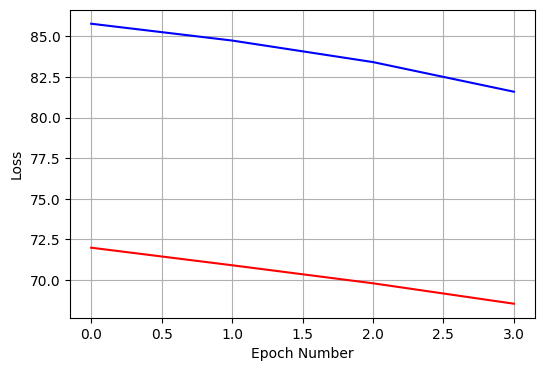

In [80]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

In [81]:
# Obtener predicciones del modelo sobre el conjunto de validación
y_pred = model.predict(ds_val)
# Obtener valores reales (etiquetas) del dataset
y_true = np.concatenate([y for x, y in ds_val], axis=0)

181/181 [==============================] - 39s 213ms/step


In [83]:
y_pred

array([[[1.4171047e+01]],

       [[1.4669630e+01]],

       [[1.3037916e+01]],

       ...,

       [[4.4221929e-03]],

       [[4.5639370e-03]],

       [[4.0441290e-03]]], dtype=float32)

In [84]:
y_true

array([[[26]],

       [[19]],

       [[17]],

       ...,

       [[ 0]],

       [[ 0]],

       [[ 0]]])

In [85]:
mae_total = tf.keras.losses.MeanAbsoluteError()
rmse_total = tf.keras.metrics.RootMeanSquaredError()

mae = mae_total(y_true, y_pred).numpy()
rmse = rmse_total(y_true, y_pred).numpy()

print(f"MAE total: {mae:.4f}")
print(f"RMSE total: {rmse:.4f}")

MAE total: 81.5861
RMSE total: 202.1692


In [92]:
def r2_score_np(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    ss_res = np.sum(np.square(y_true - y_pred))
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (ss_res / (ss_tot + 1e-7))  # pequeña constante para evitar división por 0

def bias_np(y_true, y_pred):
    return np.mean(y_pred.flatten() - y_true.flatten())

r2 = r2_score_np(y_true, y_pred)
bias = abs(bias_np(y_true, y_pred))

print(f"R²:   {r2:.4f}")
print(f"Bias: {bias:.4f}")

R²:   -0.1377
Bias: 80.5222


Realicemos el mismo modelo pero con más iteraciones:

In [5]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [6]:
# Crear nuevas etiquetas escalar por muestra (suma total de cada matriz)
y_train_scalar = ds_train.label_2d_reg.values.sum(axis=(1, 2), keepdims=True)  # shape: (n_samples, 1)
y_val_scalar   = ds_val.label_2d_reg.values.sum(axis=(1, 2), keepdims=True)    # shape: (n_samples, 1)

# Dataset de entrenamiento y validación
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values, y_train_scalar))
ds_val  = tf.data.Dataset.from_tensor_slices((ds_val.features.values, y_val_scalar))

tf.random.set_seed(42)

#Mezclamos solo el de entrenamiento
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [14]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers

model = Sequential()

# --- Encoder (3 bloques + bottleneck = profundidad 4) ---
model.add(Conv2D(32, (7, 7), padding='same', input_shape=(48, 48, 4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 24x24

model.add(Conv2D(64, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 12x12

model.add(Conv2D(128, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))  # 6x6

# --- Bottleneck ---
model.add(Conv2D(256, (7, 7), padding='same'))  # Bottleneck de 256
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# --- Decoder ---
model.add(UpSampling2D((2, 2)))  # 12x12
model.add(Conv2D(128, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

model.add(UpSampling2D((2, 2)))  # 24x24
model.add(Conv2D(64, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

model.add(UpSampling2D((2, 2)))  # 48x48
model.add(Conv2D(32, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# --- Output layer for regression ---
model.add(Conv2D(1, (1, 1), activation='linear'))
model.add(GlobalAveragePooling2D())               
model.add(Reshape((1, 1))) 

# --- Compile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

c:\Users\EQUIPO\Documents\01-05-2025-kenny\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\EQUIPO\Documents\01-05-2025-kenny\.venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │         6,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 4,224,609 (16.12 MB)

 Trainable params: 4,223,201 (16.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [15]:
history = model.fit(ds_train, validation_data=ds_val, epochs=15)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 299s 316ms/step - loss: 71.9975 - root_mean_squared_error: 193.9041 - val_loss: 84.3889 - val_root_mean_squared_error: 205.2250
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 285s 304ms/step - loss: 71.0351 - root_mean_squared_error: 190.9532 - val_loss: 81.9061 - val_root_mean_squared_error: 202.5042
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 288s 307ms/step - loss: 67.9475 - root_mean_squared_error: 185.1029 - val_loss: 80.5942 - val_root_mean_squared_error: 200.1561
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 289s 308ms/step - loss: 65.3421 - root_mean_squared_error: 182.8498 - val_loss: 78.2187 - val_root_mean_squared_error: 196.7682
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 289s 308ms/step - loss: 63.3327 - root_mean_squared_error: 179.8796 - val_loss: 76.2246 - val_root_mean_squared_error: 193.4276
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 288s 307ms/step - loss: 60.3669 - root_mean_squared_error: 176.7230 - val_loss: 73.1986 - val_root_mean_squared_error: 1

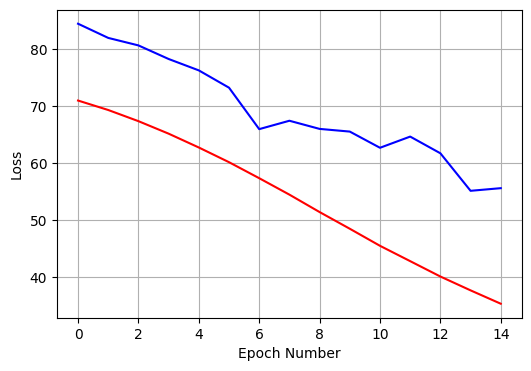

In [16]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

In [17]:
# Obtener predicciones del modelo sobre el conjunto de validación
y_pred = model.predict(ds_val)
# Obtener valores reales (etiquetas) del dataset
y_true = np.concatenate([y for x, y in ds_val], axis=0)

181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step


In [18]:
mae_total = tf.keras.losses.MeanAbsoluteError()
rmse_total = tf.keras.metrics.RootMeanSquaredError()

mae = mae_total(y_true, y_pred).numpy()
rmse = rmse_total(y_true, y_pred).numpy()

print(f"MAE total: {mae:.4f}")
print(f"RMSE total: {rmse:.4f}")

MAE total: 55.6205
RMSE total: 145.8470


In [19]:
def r2_score_np(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    ss_res = np.sum(np.square(y_true - y_pred))
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (ss_res / (ss_tot + 1e-7))  # pequeña constante para evitar división por 0

def bias_np(y_true, y_pred):
    return np.mean(y_pred.flatten() - y_true.flatten())

r2 = r2_score_np(y_true, y_pred)
bias = abs(bias_np(y_true, y_pred))

print(f"R²:   {r2:.4f}")
print(f"Bias: {bias:.4f}")

R²:   0.4079
Bias: 47.4406


## Grafica Clasificación:

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21840\2460753892.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=df, x="Modelo", y="Accuracy", palette=colors_acc, ax=ax)


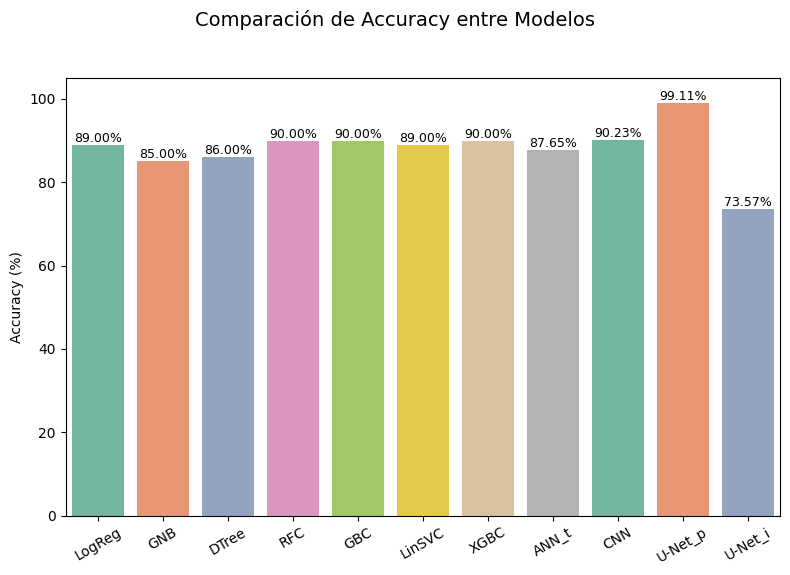

In [2]:
# Datos
data = [
    {"Modelo": "LogReg", "Accuracy": 89.0},
    {"Modelo": "GNB", "Accuracy": 85.0},
    {"Modelo": "DTree", "Accuracy": 86.0},
    {"Modelo": "RFC", "Accuracy": 90.0},
    {"Modelo": "GBC", "Accuracy": 90.0},
    {"Modelo": "LinSVC", "Accuracy": 89.0},
    {"Modelo": "XGBC", "Accuracy": 90.0},
    {"Modelo": "ANN_t", "Accuracy": 87.65},
    {"Modelo": "CNN", "Accuracy": 90.23},
    {"Modelo": "U-Net_p", "Accuracy": 99.11},
    {"Modelo": "U-Net_i", "Accuracy": 73.57},
]

df = pd.DataFrame(data)

# Paleta de colores
colors_acc = sns.color_palette("Set2", n_colors=len(df))

# Crear figura
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Comparación de Accuracy entre Modelos", fontsize=14)

# Gráfico de barras
bars = sns.barplot(data=df, x="Modelo", y="Accuracy", palette=colors_acc, ax=ax)

# Etiquetas sobre las barras
for bar in bars.patches:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}%", 
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, color='black')

# Estética
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("")
ax.tick_params(axis='x', rotation=30)
plt.ylim(0, 105)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Grafica Regresion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21840\1595779561.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21840\1595779561.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21840\1595779561.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
C:\Users\Usua

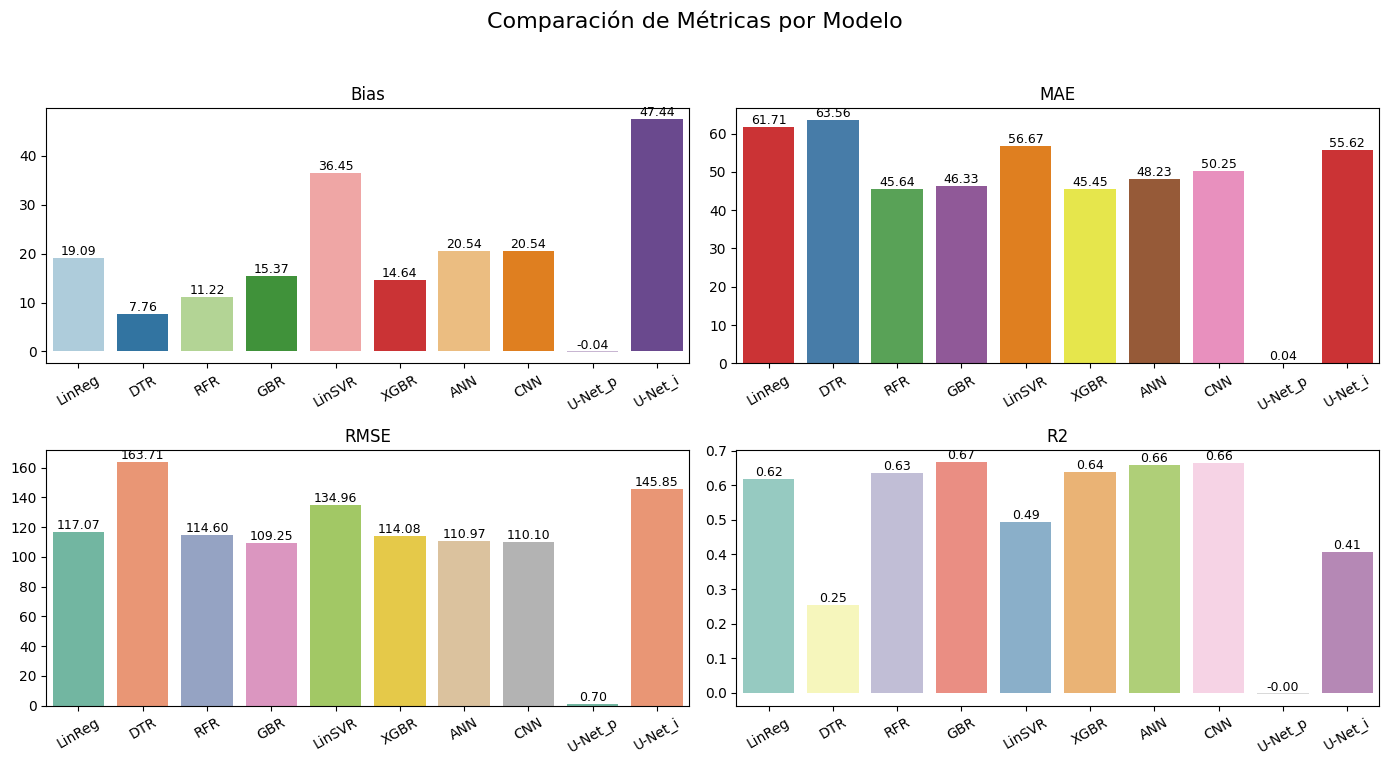

In [3]:
# Datos
data = [
    {"Metodo": "LinReg", "R2": 0.6185, "MAE": 61.7133, "RMSE": 117.0673, "Bias": 19.0938},
    {"Metodo": "DTR", "R2": 0.2540, "MAE": 63.5563, "RMSE": 163.7067, "Bias": 7.7641},
    {"Metodo": "RFR", "R2": 0.6344, "MAE": 45.6393, "RMSE": 114.6000, "Bias": 11.2243},
    {"Metodo": "GBR", "R2": 0.6678, "MAE": 46.3343, "RMSE": 109.2468, "Bias": 15.3743},
    {"Metodo": "LinSVR", "R2": 0.4930, "MAE": 56.6742, "RMSE": 134.9611, "Bias": 36.4499},
    {"Metodo": "XGBR", "R2": 0.6377, "MAE": 45.4488, "RMSE": 114.0848, "Bias": 14.6450},
    {"Metodo": "ANN", "R2": 0.6572, "MAE": 48.2326, "RMSE": 110.9742, "Bias": 20.5387},
    {"Metodo": "CNN", "R2": 0.6626, "MAE": 50.25, "RMSE": 110.10, "Bias": 20.5387},
    {"Metodo": "U-Net_p", "R2": -0.0028, "MAE": 0.0392, "RMSE": 0.7047, "Bias": -0.0369},
    {"Metodo": "U-Net_i", "R2": 0.4079, "MAE": 55.6205, "RMSE": 145.8470, "Bias": 47.4406},
]

df = pd.DataFrame(data)

# Paletas de color
colors_mae = sns.color_palette("Set1", n_colors=len(df))
colors_rmse = sns.color_palette("Set2", n_colors=len(df))
colors_r2 = sns.color_palette("Set3", n_colors=len(df))
colors_bias = sns.color_palette("Paired", n_colors=len(df))

# Ejes y tamaño
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("Comparación de Métricas por Modelo", fontsize=16)

# Métricas para cada Plot
metrics = [
    ("Bias", colors_bias, axes[0, 0], "%.2f"),
    ("MAE", colors_mae, axes[0, 1], "%.2f"),
    ("RMSE", colors_rmse, axes[1, 0], "%.2f"),
    ("R2", colors_r2, axes[1, 1], "%.2f")
]

# Crear subplots
for metric, palette, ax, fmt in metrics:
    bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=30)

    for bar in bars.patches:
        height = bar.get_height()
        ax.annotate(fmt % height,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Grafica Comparativa Modelos Propios y Articulo

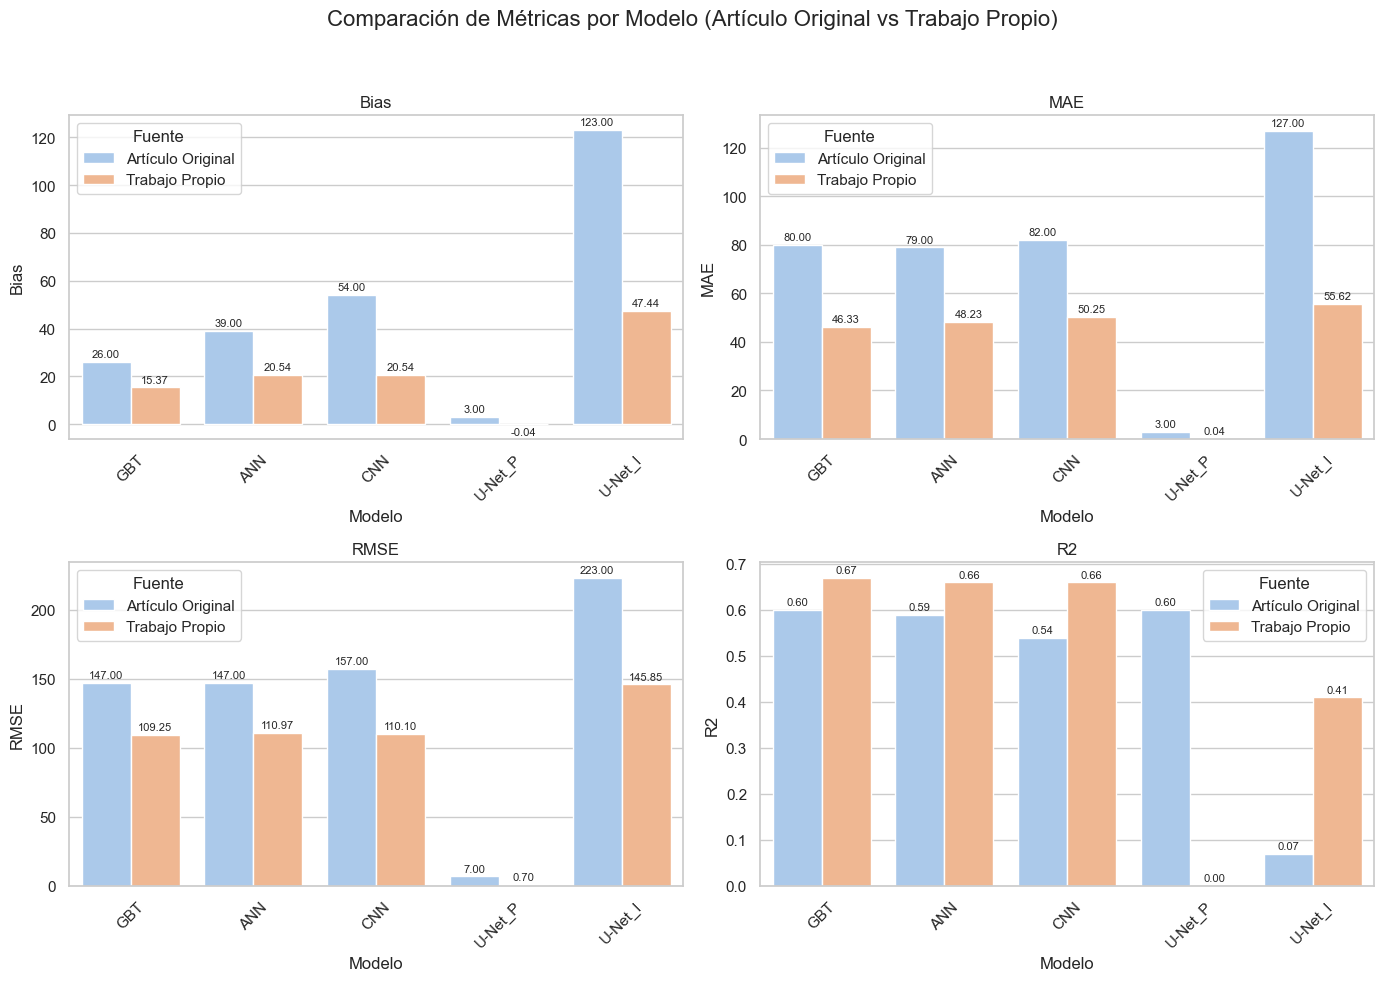

In [4]:
# Datos Artículo Original
datos_articulo = {
    'Modelo': ['GBT', 'ANN', 'CNN', 'U-Net_P', 'U-Net_I'],
    'Bias': [26, 39, 54, 3, 123],
    'MAE': [80, 79, 82, 3, 127],
    'RMSE': [147, 147, 157, 7, 223],
    'R2': [0.60, 0.59, 0.54, 0.60, 0.07],
    'Fuente': ['Artículo Original'] * 5
}

# Datos Trabajo Propio
datos_trabajo = {
    'Modelo': ['GBT', 'ANN', 'CNN', 'U-Net_P', 'U-Net_I'],
    'Bias': [15.37, 20.54, 20.54, -0.04, 47.44],
    'MAE': [46.33, 48.23, 50.25, 0.04, 55.62],
    'RMSE': [109.25, 110.97, 110.1, 0.7, 145.85],
    'R2': [0.67, 0.66, 0.66, -0.00, 0.41],
    'Fuente': ['Trabajo Propio'] * 5
}

# DataFrames
df_articulo = pd.DataFrame(datos_articulo)
df_trabajo = pd.DataFrame(datos_trabajo)
df = pd.concat([df_articulo, df_trabajo], ignore_index=True)

# Lista de métricas
metricas = ['Bias', 'MAE', 'RMSE', 'R2']

# Estilo
sns.set(style='whitegrid')

# Crear subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Generar un gráfico por métrica
for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.barplot(data=df, x='Modelo', y=metrica, hue='Fuente', palette='pastel', ax=ax)

    # Añadir etiquetas a las barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

    ax.set_title(f'{metrica}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metrica)

# Ajustar
fig.suptitle('Comparación de Métricas por Modelo (Artículo Original vs Trabajo Propio)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Guardar modelo

In [3]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [4]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [5]:
model = models.unet_2d([48,48,4],[2,4],1,stack_num_down=1,stack_num_up=1,output_activation='Sigmoid',weights=None)
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 unet_down0_0 (Conv2D)          (None, 48, 48, 2)    74          ['input_1[0][0]']                
                                                                                                  
 unet_down0_0_activation (ReLU)  (None, 48, 48, 2)   0           ['unet_down0_0[0][0]']           
                                                                                                  
 unet_down1_encode_maxpool (Max  (None, 24, 24, 2)   0           ['unet_down0_0_activation[0][0]']
 Pooling2D)                                                                              

In [6]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics='accuracy')

history = model.fit(ds_train,validation_data=ds_val,epochs=5)

Epoch 1/5
938/938 [==============================] - 193s 204ms/step - loss: 0.0707 - accuracy: 0.9909 - val_loss: 0.0378 - val_accuracy: 0.9901
Epoch 2/5
938/938 [==============================] - 191s 203ms/step - loss: 0.0302 - accuracy: 0.9909 - val_loss: 0.0320 - val_accuracy: 0.9901
Epoch 3/5
938/938 [==============================] - 193s 206ms/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 0.0306 - val_accuracy: 0.9901
Epoch 4/5
938/938 [==============================] - 193s 206ms/step - loss: 0.0269 - accuracy: 0.9909 - val_loss: 0.0300 - val_accuracy: 0.9901
Epoch 5/5
938/938 [==============================] - 190s 203ms/step - loss: 0.0262 - accuracy: 0.9909 - val_loss: 0.0294 - val_accuracy: 0.9901


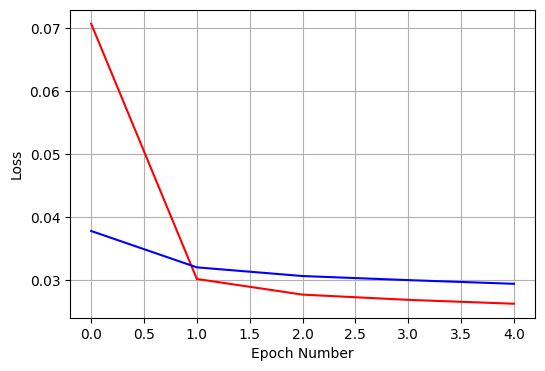

In [7]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

In [8]:
for batch in ds_val:
    break 

In [10]:
y_preds = model.predict(ds_val)

181/181 [==============================] - 1s 4ms/step


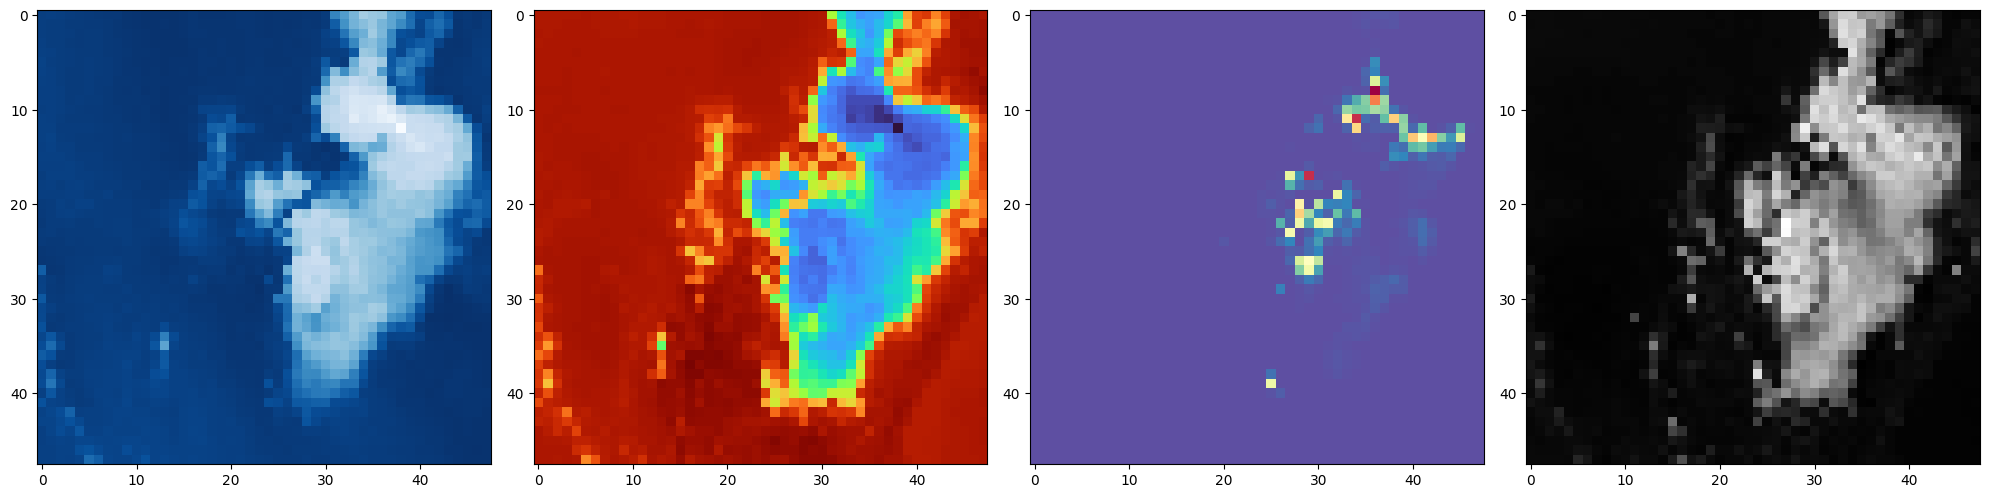

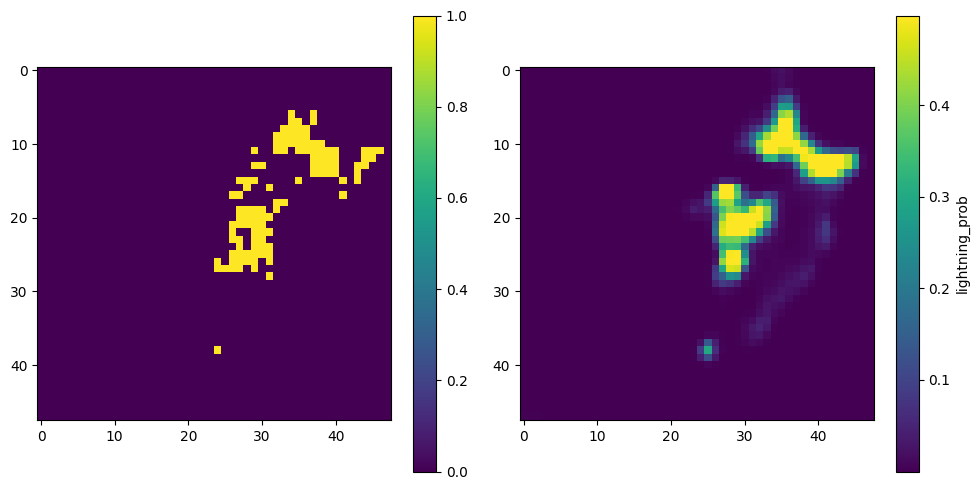

In [11]:
#get the features for example 26 in this batch 
one_example_features = batch[0][25]
#get the label for that same example 
one_example_label = batch[1][25]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[25])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

Una vez visto que todo funciona correctamente, se procede a guardar el modelo.

In [13]:
model.save('modelo_u_net_clas.h5')

Si se quisiera volver a cargar se haría de la siguiente forma.

In [15]:
modelo = load_model('modelo_u_net_clas.h5')

In [17]:
y_preds = modelo.predict(ds_val)

181/181 [==============================] - 1s 4ms/step


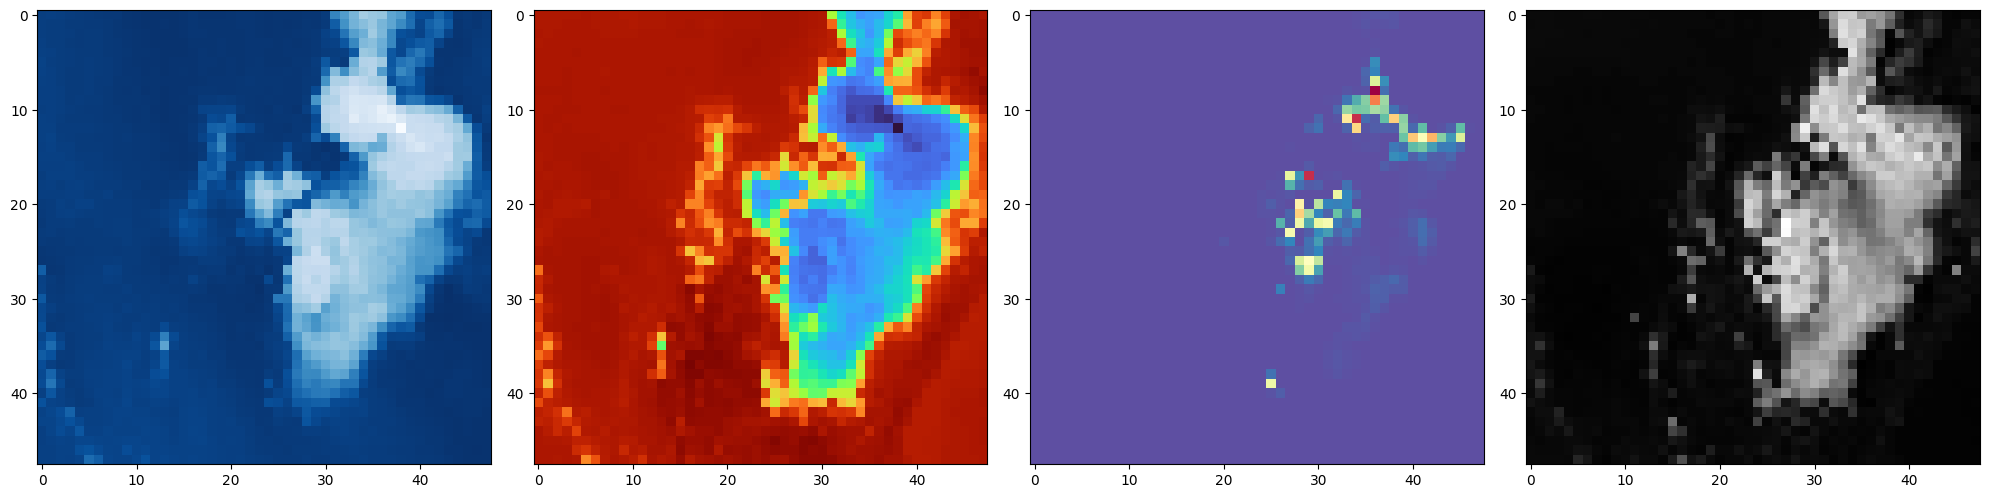

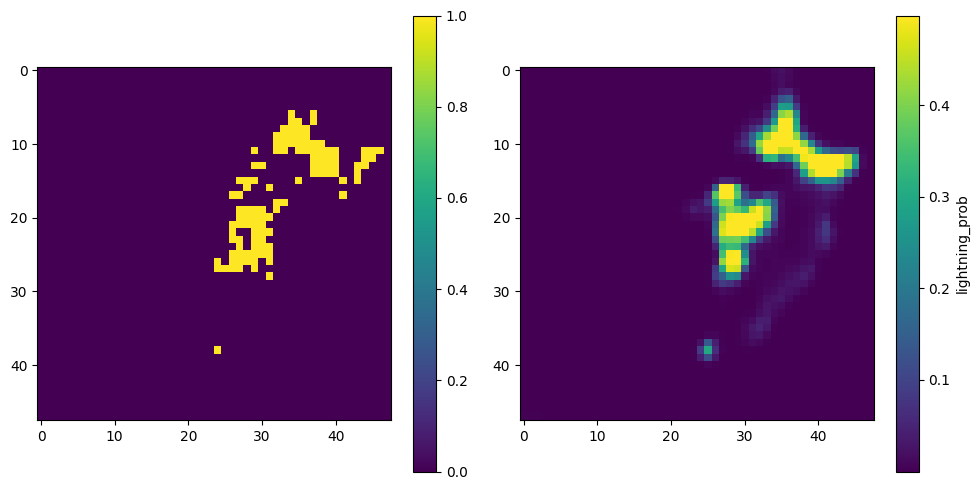

In [18]:
#get the features for example 26 in this batch 
one_example_features = batch[0][25]
#get the label for that same example 
one_example_label = batch[1][25]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[25])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

Da el mismo resultado, así que está correcto.

## Datos para Gradio:

Se vuelve a realizar el mismo tratamiento de los datos:

In [2]:
ds_train = xr.open_dataset('sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir-val.zarr',engine='zarr')

In [3]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [4]:
ds_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 48), dtype=tf.int8, name=None))>

In [82]:
# Extraer tres muestras del conjunto de validación
indices = [4, 27, 44]
muestras_entradas = []
muestras_salidas = []

for i, (x, y) in enumerate(ds_val.unbatch().take(max(indices)+1)):
    if i in indices:
        muestras_entradas.append(x.numpy())
        muestras_salidas.append(y.numpy())

# Mostrar las formas y datos
print("Entradas:")
print(muestras_entradas)

Entradas:
[array([[[-0.00538153,  0.02540341, -0.2063957 , -0.6947736 ],
        [ 0.17300098,  0.62024355, -0.2063957 , -0.6980867 ],
        [ 0.13008831,  0.5946674 , -0.2063957 , -0.6966668 ],
        ...,
        [ 0.9748813 ,  1.282512  , -0.2063957 , -0.6980867 ],
        [ 0.98666126,  1.2918123 , -0.2063957 , -0.6957202 ],
        [ 0.9580527 ,  1.2778616 , -0.2063957 , -0.6980867 ]],

       [[ 0.0063984 ,  0.1071697 , -0.2063957 , -0.6980867 ],
        [ 0.16037975,  0.619856  , -0.2063957 , -0.6966668 ],
        [ 0.07034674,  0.59389234, -0.2063957 , -0.6980867 ],
        ...,
        [ 1.0034899 ,  1.2968501 , -0.2063957 , -0.6980867 ],
        [ 0.9647841 ,  1.2852246 , -0.2063957 , -0.6980867 ],
        [ 0.96225995,  1.275924  , -0.2063957 , -0.6976134 ]],

       [[ 0.04510398,  0.25597662, -0.2063957 , -0.69288033],
        [ 0.02743408,  0.4993379 , -0.2063957 , -0.6966668 ],
        [ 0.13597828,  0.7016223 , -0.2063957 , -0.6943003 ],
        ...,
        [ 0.9546

In [83]:
print("\nSalidas:")
#print(muestras_salidas.shap)
print(muestras_salidas)


Salidas:
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)]


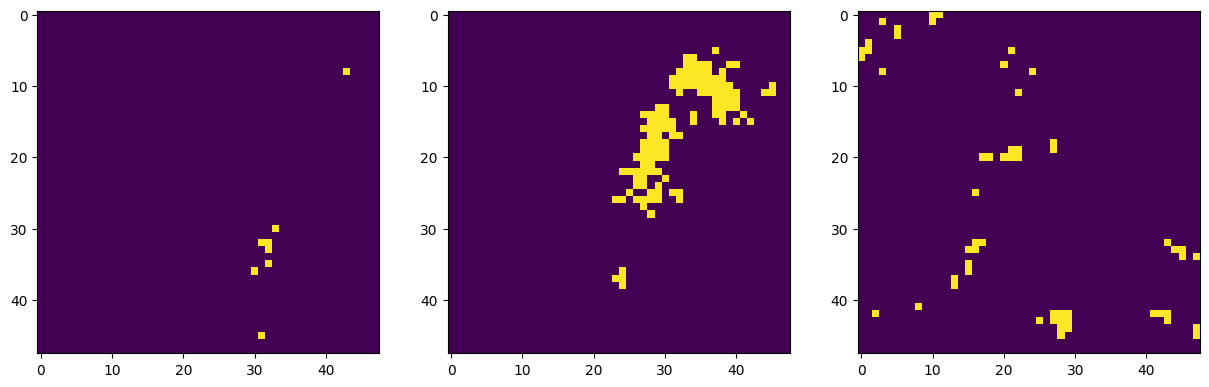

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(muestras_salidas[0])
axes[1].imshow(muestras_salidas[1])
axes[2].imshow(muestras_salidas[2])

Guardemos esas entradas

In [6]:
modelo = load_model('modelo_u_net_clas.h5')

In [91]:
# 1. Eliminar batching para acceder a imágenes individuales
ds_val_unbatched = ds_val.unbatch()

# 2. Convertir a lista para indexar directamente
ds_val_list = list(ds_val_unbatched)

# 3. Seleccionar imágenes por índice (muestras 4, 27 y 44)
indices = [4, 27, 44]
X_selected = np.array([ds_val_list[i][0].numpy() for i in indices])

# 4. Guardar el array en un archivo .npy (opcional)
np.save('X_seleccionadas.npy', X_selected)

# 5. Realizar predicción con el modelo
predictions = modelo.predict(X_selected)

1/1 [==============================] - 0s 16ms/step


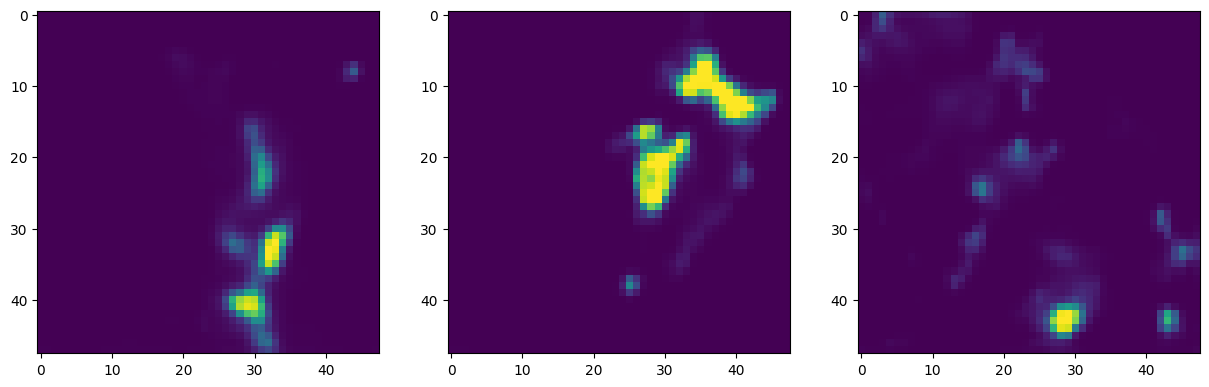

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(predictions[0])
axes[1].imshow(predictions[1])
axes[2].imshow(predictions[2])

In [9]:
# 1. Eliminar batching para acceder a imágenes individuales
ds_val_unbatched = ds_val.unbatch()

# 2. Convertir a lista para indexar directamente
ds_val_list = list(ds_val_unbatched)

# 3. Seleccionar imágenes por índice (muestras 4, 27 y 44)
indices = [27]
X_selected = np.array([ds_val_list[i][0].numpy() for i in indices])
y_selected = np.array([ds_val_list[i][1].numpy() for i in indices])

# 4. Guardar el array en un archivo .npy (opcional)
np.save('X_primer_ej.npy', X_selected)
np.save('y_primer_ej.npy', y_selected)

In [10]:
# 1. Eliminar batching para acceder a imágenes individuales
ds_val_unbatched = ds_val.unbatch()

# 2. Convertir a lista para indexar directamente
ds_val_list = list(ds_val_unbatched)

# 3. Seleccionar imágenes por índice (muestras 4, 27 y 44)
indices = [4]
X_selected = np.array([ds_val_list[i][0].numpy() for i in indices])
y_selected = np.array([ds_val_list[i][1].numpy() for i in indices])

# 4. Guardar el array en un archivo .npy (opcional)
np.save('X_seg_ej.npy', X_selected)
np.save('y_seg_ej.npy', y_selected)

In [11]:
# 1. Eliminar batching para acceder a imágenes individuales
ds_val_unbatched = ds_val.unbatch()

# 2. Convertir a lista para indexar directamente
ds_val_list = list(ds_val_unbatched)

# 3. Seleccionar imágenes por índice (muestras 4, 27 y 44)
indices = [44]
X_selected = np.array([ds_val_list[i][0].numpy() for i in indices])
y_selected = np.array([ds_val_list[i][1].numpy() for i in indices])

# 4. Guardar el array en un archivo .npy (opcional)
np.save('X_tercer_ej.npy', X_selected)
np.save('y_tercer_ej.npy', y_selected)